**Evaluating the impact of FOMC Communications (press releases, Meeting Minutes, and speeches) on Asset Prices**

Following the analysis discussed in class sessions on how to analyze the impact of FOMC communications on major market benchmarks such as US Treasuries and Fed Funds futures markets, evaluate how the dovishness or hawkishness of these communications have been reflected in relevant markets.

Determine statistical significance in your analysis.

Go back to October 2020 for gathering relevant FOMC communications.

The speeches and press releases are available at www.federalreserve.gov

Market data is available from your WRDS account.



**Team Member:**

Sally Yang

Lucy Yu

Robben Tian (ct1822)

**Step 1: Import Libraries**

In [ ]:
import pandas as pd, numpy as np, statsmodels.api as sm
from pathlib import Path

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch, torch.nn.functional as F

name = "ProsusAI/finbert"

tok = AutoTokenizer.from_pretrained(name)
model = AutoModelForSequenceClassification.from_pretrained(name)
model.eval().to("cuda" if torch.cuda.is_available() else "cpu")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
model.save_pretrained("finbert_local")
tok.save_pretrained("finbert_local")

from transformers import AutoTokenizer, AutoModelForSequenceClassification
tok = AutoTokenizer.from_pretrained("finbert_local")
model = AutoModelForSequenceClassification.from_pretrained("finbert_local")


**Step 2: Parsing Speech**


In [ ]:
import re
import csv
import time
import json
import random
import datetime as dt
from pathlib import Path

import requests
from bs4 import BeautifulSoup

BASE = "https://www.federalreserve.gov"
HEADERS = {
    "User-Agent": "SallyYang NYU (research) - email@example.com",
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
}

START_DATE = dt.date(2020, 10, 1)
END_DATE   = dt.date(2025, 10, 7)

YEARS = list(range(START_DATE.year, END_DATE.year + 1))

OUT_CSV = "fed_speeches_20201001_20251007.csv"

# ---------- helpers ----------
def safe_get(url, try_pdf=False, timeout=20):
    for i in range(3):
        try:
            r = requests.get(url, headers=HEADERS, timeout=timeout)
            if r.status_code == 200:
                return r
        except requests.RequestException:
            pass
        time.sleep(1 + i)
    return None

DATE_IN_URL = re.compile(r"(\d{4})(\d{2})(\d{2})")  # e.g., bowman20251007a.htm

def parse_date_from_url(url_path: str):
    m = DATE_IN_URL.search(url_path)
    if not m:
        return None
    y, mth, d = map(int, m.groups())
    try:
        return dt.date(y, mth, d)
    except ValueError:
        return None

def clean_text(x: str):
    return re.sub(r"\s+", " ", x or "").strip()

def extract_pdf_url(soup, html_url):
    # Common placement: <a href="/newsevents/speech/files/....pdf">PDF</a>
    # Or top right corner link
    pdf = None
    for a in soup.find_all("a", href=True):
        href = a["href"]
        if href.lower().endswith(".pdf") and "/newsevents/speech/" in href:
            pdf = href if href.startswith("http") else BASE + href
            break
    return pdf

def extract_title_and_byline(soup):
    # The internal structure has changed slightly, so we try to be robust.
    # Usually <h3>Title</h3> or <h1>Title</h1>
    title = None
    for tag in ["h1", "h2", "h3"]:
        h = soup.find(tag)
        if h and clean_text(h.get_text()):
            title = clean_text(h.get_text())
            break

    # byline often contains person, role, location, date, etc.
    byline = ""
    byline_container = soup.find("div", class_=re.compile(r"(byline|speaker|subtitle|pubdate)", re.I))
    if byline_container:
        byline = clean_text(byline_container.get_text(" "))

    if not byline:
        em = soup.find(["p", "div"], class_=re.compile(r"(subtitle|article__subhead)", re.I))
        if em:
            byline = clean_text(em.get_text(" "))

    return title, byline

def parse_person_and_org(byline_text):
     # Try to extract "Person Name" and "Role/Organization"
    # Ex. "Michelle W. Bowman Vice Chair for Supervision Board of Governors of the Federal Reserve System ..."
    person, role_org = None, None
    # Split by newline/two spaces/" at "/dash
    parts = re.split(r"\s{2,}| at | – |- ", byline_text)
    if parts:
        # The first token is often "Name Title"
        first = parts[0]
        # If it contains common title words, treat it as role_org; otherwise, as person
        title_words = ["Chair", "Governor", "Vice", "President", "Economist", "Director", "Advisor", "Board"]
        if any(w.lower() in first.lower() for w in title_words):
            role_org = first
        else:
            person = first
    # Then, if role_org is still empty, try to find title words in the whole byline
    if not person:
        m = re.search(r"(Jerome H\. Powell|Jerome Powell|Michelle W\. Bowman|Philip N\. Jefferson|Christopher J\. Waller|Michael S\. Barr|Adriana Kugler|Lisa D\. Cook|Lael Brainard|Randal K\. Quarles|Janet L\. Yellen)", byline_text)
        if m:
            person = m.group(1)
    return clean_text(person or ""), clean_text(role_org or "")

def extract_location(soup, byline_text):
    # Many pages mention locations in the byline or the first paragraph, such as "St. Louis, Missouri" / "Dallas, Texas"
    # Try to find patterns like "City, State"
    m = re.search(r"([A-Z][A-Za-z\.\- ]+,\s*[A-Z][A-Za-z\.\- ]+)", byline_text)
    if m:
        return clean_text(m.group(1))

    p = soup.find("p")
    if p:
        txt = clean_text(p.get_text(" "))
        m2 = re.search(r"([A-Z][A-Za-z\.\- ]+,\s*[A-Z][A-Za-z\.\- ]+)", txt)
        if m2:
            return clean_text(m2.group(1))
    return ""

def parse_speech_page(url):
    r = safe_get(url)
    if not r:
        return {}
    soup = BeautifulSoup(r.text, "html.parser")

    title, byline = extract_title_and_byline(soup)
    pdf_url = extract_pdf_url(soup, url)
    location = extract_location(soup, byline)

    date = parse_date_from_url(url)
    if not date:
        m = re.search(r"(January|February|March|April|May|June|July|August|September|October|November|December)\s+\d{1,2},\s+\d{4}", soup.get_text(" "))
        if m:
            try:
                date = dt.datetime.strptime(m.group(0), "%B %d, %Y").date()
            except:
                pass

    person, role_org = parse_person_and_org(byline)

    return {
        "date": date.isoformat() if date else "",
        "title": title,
        "person": person,
        "role_org": role_org,
        "location": location,
        "url_html": url,
        "url_pdf": pdf_url or "",
        "byline_raw": byline,
    }

def iter_year_listing(year: int):
    url = f"{BASE}/newsevents/speech/{year}-speeches.htm"
    r = safe_get(url)
    if not r:
        return []
    soup = BeautifulSoup(r.text, "html.parser")

    # 抓所有 /newsevents/speech/*YYYYMMDD*.htm 或 .pdf 的链接
    links = set()
    for a in soup.find_all("a", href=True):
        href = a["href"]
        if "/newsevents/speech/" in href:
            if href.endswith(".htm") or href.endswith(".pdf"):
                full = href if href.startswith("http") else BASE + href
                # 仅保留含日期的条目
                if DATE_IN_URL.search(full) or full.lower().endswith(".pdf"):
                    links.add(full)
    return sorted(links)

def main():
    rows = []
    seen_html_keys = set()

    for y in YEARS:
        print(f"== Year {y} ==")
        year_links = iter_year_listing(y)
        random.shuffle(list(year_links))
        for link in year_links:
            # 规范成 HTML 页：如果是 PDF 直链，跳过（稍后用 HTML 页补）；如果只有 PDF，也会记录

            if link.lower().endswith(".pdf"):
                # 尝试找到对应的 html 名（经验：pdf 在 /files/ 下，以相同基名）
                base = Path(link).name  # e.g., bowman20251007a.pdf
                html_guess = link.replace("/files/", "/").replace(".pdf", ".htm")
                # 以 html_guess 为主
                target = html_guess
            else:
                target = link

            if target in seen_html_keys:
                continue
            seen_html_keys.add(target)

            data = parse_speech_page(target)
            # 日期过滤
            if data.get("date"):
                d = dt.date.fromisoformat(data["date"])
                if not (START_DATE <= d <= END_DATE):
                    continue

            # 若 pdf 仍空，再尝试从“猜测路径”抓一下
            if not data.get("url_pdf"):
                m = DATE_IN_URL.search(target)
                if m:
                    # 形如 .../bowman20251007a.htm -> /files/bowman20251007a.pdf
                    pdf_guess = target.replace("/speech/", "/speech/files/").replace(".htm", ".pdf")
                    if safe_get(pdf_guess):
                        data["url_pdf"] = pdf_guess

            if data:
                rows.append(data)
            time.sleep(0.2)

    # 去重（按 url_html + date）
    uniq = {}
    for r in rows:
        key = (r.get("url_html",""), r.get("date",""))
        if key not in uniq:
            uniq[key] = r
    rows = list(uniq.values())
    rows.sort(key=lambda x: (x.get("date",""), x.get("person",""), x.get("title","")))

    # 保存
    cols = ["date", "person", "role_org", "title", "location", "url_html", "url_pdf", "byline_raw"]
    with open(OUT_CSV, "w", newline="", encoding="utf-8") as f:
        w = csv.DictWriter(f, fieldnames=cols)
        w.writeheader()
        for r in rows:
            w.writerow({k: r.get(k, "") for k in cols})
    print(f"Saved {len(rows)} speeches to {OUT_CSV}")

if __name__ == "__main__":
    main()


== Year 2020 ==
== Year 2021 ==
== Year 2022 ==


KeyboardInterrupt: 

In [ ]:
FED_SPEECH_URL = [
    "https://www.federalreserve.gov/newsevents/speech/bowman20201001a.htm",
    "https://www.federalreserve.gov/newsevents/speech/brainard20201001a.htm",
    "https://www.federalreserve.gov/newsevents/speech/powell20201006a.htm",
    "https://www.federalreserve.gov/newsevents/speech/clarida20201014a.htm",
    "https://www.federalreserve.gov/newsevents/speech/quarles20201014a.htm",
    "https://www.federalreserve.gov/newsevents/speech/brainard20201015a.htm",
    "https://www.federalreserve.gov/newsevents/speech/quarles20201015a.htm",
    "https://www.federalreserve.gov/newsevents/speech/clarida20201019a.htm",
    "https://www.federalreserve.gov/newsevents/speech/brainard20201020a.htm",
    "https://www.federalreserve.gov/newsevents/speech/quarles20201020a.htm",
    "https://www.federalreserve.gov/newsevents/speech/brainard20201021a.htm",
    "https://www.federalreserve.gov/newsevents/speech/brainard20201110a.htm",
    "https://www.federalreserve.gov/newsevents/speech/clarida20201116a.htm",
    "https://www.federalreserve.gov/newsevents/speech/brainard20201117a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20201119a.htm",
    "https://www.federalreserve.gov/newsevents/speech/brainard20201201a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20201204a.htm",
    "https://www.federalreserve.gov/newsevents/speech/quarles20201211a.htm",
    "https://www.federalreserve.gov/newsevents/speech/brainard20201217a.htm",
    "https://www.federalreserve.gov/newsevents/speech/brainard20201218a.htm",
    "https://www.federalreserve.gov/newsevents/speech/clarida20210108a.htm",
    "https://www.federalreserve.gov/newsevents/speech/brainard20210112a.htm",
    "https://www.federalreserve.gov/newsevents/speech/brainard20210113a.htm",
    "https://www.federalreserve.gov/newsevents/speech/clarida20210113a.htm",
    "https://www.federalreserve.gov/newsevents/speech/powell20210210a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20210216a.htm",
    "https://www.federalreserve.gov/newsevents/speech/brainard20210218a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20210222a.htm",
    "https://www.federalreserve.gov/newsevents/speech/brainard20210224a.htm",
    "https://www.federalreserve.gov/newsevents/speech/clarida20210224a.htm",
    "https://www.federalreserve.gov/newsevents/speech/quarles20210225a.htm",
    "https://www.federalreserve.gov/newsevents/speech/brainard20210301a.htm",
    "https://www.federalreserve.gov/newsevents/speech/brainard20210302a.htm",
    "https://www.federalreserve.gov/newsevents/speech/powell20210318a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20210322a.htm",
    "https://www.federalreserve.gov/newsevents/speech/quarles20210322a.htm",
    "https://www.federalreserve.gov/newsevents/speech/brainard20210323a.htm",
    "https://www.federalreserve.gov/newsevents/speech/brainard20210323b.htm",
    "https://www.federalreserve.gov/newsevents/speech/clarida20210325a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20210329a.htm",
    "https://www.federalreserve.gov/newsevents/speech/quarles20210330a.htm",
    "https://www.federalreserve.gov/newsevents/speech/clarida20210414a.htm",
    "https://www.federalreserve.gov/newsevents/speech/powell20210503a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20210505a.htm",
    "https://www.federalreserve.gov/newsevents/speech/brainard20210511a.htm",
    "https://www.federalreserve.gov/newsevents/speech/clarida20210512a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20210513a.htm",
    "https://www.federalreserve.gov/newsevents/speech/clarida20210517a.htm",
    "https://www.federalreserve.gov/newsevents/speech/brainard20210524a.htm",
    "https://www.federalreserve.gov/newsevents/speech/quarles20210526a.htm",
    "https://www.federalreserve.gov/newsevents/speech/quarles20210526b.htm",
    "https://www.federalreserve.gov/newsevents/speech/brainard20210601a.htm",
    "https://www.federalreserve.gov/newsevents/speech/quarles20210603a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20210623a.htm",
    "https://www.federalreserve.gov/newsevents/speech/quarles20210628a.htm",
    "https://www.federalreserve.gov/newsevents/speech/quarles20210711a.htm",
    "https://www.federalreserve.gov/newsevents/speech/brainard20210730a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20210803a.htm",
    "https://www.federalreserve.gov/newsevents/speech/clarida20210804a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20210805a.htm",
    "https://www.federalreserve.gov/newsevents/speech/powell20210817a.htm",
    "https://www.federalreserve.gov/newsevents/speech/powell20210827a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20210909a.htm",
    "https://www.federalreserve.gov/newsevents/speech/powell20210924a.htm",
    "https://www.federalreserve.gov/newsevents/speech/brainard20210927a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20210928a.htm",
    "https://www.federalreserve.gov/newsevents/speech/quarles20211005a.htm",
    "https://www.federalreserve.gov/newsevents/speech/brainard20211007a.htm",
    "https://www.federalreserve.gov/newsevents/speech/clarida20211012a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20211013a.htm",
    "https://www.federalreserve.gov/newsevents/speech/brainard20211013a.htm",
    "https://www.federalreserve.gov/newsevents/speech/quarles20211018a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20211019a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20211019a.htm",
    "https://www.federalreserve.gov/newsevents/speech/quarles20211020a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20211022a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20211108a.htm",
    "https://www.federalreserve.gov/newsevents/speech/clarida20211108a.htm",
    "https://www.federalreserve.gov/newsevents/speech/powell20211108a.htm",
    "https://www.federalreserve.gov/newsevents/speech/powell20211109a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20211117a.htm",
    "https://www.federalreserve.gov/newsevents/speech/clarida20211119a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20211119a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20211129a.htm",
    "https://www.federalreserve.gov/newsevents/speech/powell20211129a.htm",
    "https://www.federalreserve.gov/newsevents/speech/clarida20211130a.htm",
    "https://www.federalreserve.gov/newsevents/speech/quarles20211202a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20211217a.htm",
    "https://www.federalreserve.gov/newsevents/speech/brainard20220218a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20220218a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20220221a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20220224a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20220318a.htm",
    "https://www.federalreserve.gov/newsevents/speech/powell20220321a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20220324a.htm",
    "https://www.federalreserve.gov/newsevents/speech/brainard20220405a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20220506a.htm",
    "https://www.federalreserve.gov/newsevents/speech/powell20220524a.htm",
    "https://www.federalreserve.gov/newsevents/speech/brainard20220525a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20220530a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20220603a.htm",
    "https://www.federalreserve.gov/newsevents/speech/powell20220617a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20220618a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20220623a.htm",
    "https://www.federalreserve.gov/newsevents/speech/brainard20220708a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20220714a.htm",
    "https://www.federalreserve.gov/newsevents/speech/brainard20220719a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20220806a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20220817a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20220817b.htm",
    "https://www.federalreserve.gov/newsevents/speech/powell20220826a.htm",
    "https://www.federalreserve.gov/newsevents/speech/brainard20220829a.htm",
    "https://www.federalreserve.gov/newsevents/speech/barr20220907a.htm",
    "https://www.federalreserve.gov/newsevents/speech/brainard20220907a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20220909a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20220928a.htm",
    "https://www.federalreserve.gov/newsevents/speech/powell20220928a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20220930a.htm",
    "https://www.federalreserve.gov/newsevents/speech/brainard20220930a.htm",
    "https://www.federalreserve.gov/newsevents/speech/jefferson20221004a.htm",
    "https://www.federalreserve.gov/newsevents/speech/cook20221006a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20221006a.htm",
    "https://www.federalreserve.gov/newsevents/speech/brainard20221010a.htm",
    "https://www.federalreserve.gov/newsevents/speech/barr20221012a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20221012a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20221014a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20221020a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20221116a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20221117a.htm",
    "https://www.federalreserve.gov/newsevents/speech/jefferson20221117a.htm",
    "https://www.federalreserve.gov/newsevents/speech/brainard20221128a.htm",
    "https://www.federalreserve.gov/newsevents/speech/cook20221130a.htm",
    "https://www.federalreserve.gov/newsevents/speech/powell20221130a.htm",
    "https://www.federalreserve.gov/newsevents/speech/barr20221201a.htm",
    "https://www.federalreserve.gov/newsevents/speech/cook20230106a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20230110a.htm",
    "https://www.federalreserve.gov/newsevents/speech/powell20230110a.htm",
    "https://www.federalreserve.gov/newsevents/speech/brainard20230119a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20230120a.htm",
    "https://www.federalreserve.gov/newsevents/speech/cook20230121a.htm",
    "https://www.federalreserve.gov/newsevents/speech/barr20230207a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20230208a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20230210a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20230213a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20230215a.htm",
    "https://www.federalreserve.gov/newsevents/speech/cook20230216a.htm",
    "https://www.federalreserve.gov/newsevents/speech/jefferson20230224a.htm",
    "https://www.federalreserve.gov/newsevents/speech/jefferson20230227a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20230302a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20230303a.htm",
    "https://www.federalreserve.gov/newsevents/speech/barr20230309a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20230314a.htm",
    "https://www.federalreserve.gov/newsevents/speech/jefferson20230327a.htm",
    "https://www.federalreserve.gov/newsevents/speech/barr20230329a.htm",
    "https://www.federalreserve.gov/newsevents/speech/cook20230331a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20230331a.htm",
    "https://www.federalreserve.gov/newsevents/speech/cook20230404a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20230414a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20230414a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20230418a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20230420a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20230420a.htm",
    "https://www.federalreserve.gov/newsevents/speech/cook20230421a.htm",
    "https://www.federalreserve.gov/newsevents/speech/cook20230505a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20230511a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20230512a.htm",
    "https://www.federalreserve.gov/newsevents/speech/jefferson20230512a.htm",
    "https://www.federalreserve.gov/newsevents/speech/cook20230513a.htm",
    "https://www.federalreserve.gov/newsevents/speech/cook20230515a.htm",
    "https://www.federalreserve.gov/newsevents/speech/jefferson20230518a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20230519a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20230524a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20230531a.htm",
    "https://www.federalreserve.gov/newsevents/speech/jefferson20230531a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20230616a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20230622a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20230622a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20230625a.htm",
    "https://www.federalreserve.gov/newsevents/speech/powell20230629a.htm",
    "https://www.federalreserve.gov/newsevents/speech/barr20230710a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20230713a.htm",
    "https://www.federalreserve.gov/newsevents/speech/barr20230718a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20230805a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20230807a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20230822a.htm",
    "https://www.federalreserve.gov/newsevents/speech/powell20230825a.htm",
    "https://www.federalreserve.gov/newsevents/speech/barr20230908a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20230922a.htm",
    "https://www.federalreserve.gov/newsevents/speech/cook20230922a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20230926a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20230927a.htm",
    "https://www.federalreserve.gov/newsevents/speech/cook20230928a.htm",
    "https://www.federalreserve.gov/newsevents/speech/powell20230928a.htm",
    "https://www.federalreserve.gov/newsevents/speech/barr20231002a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20231002a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20231004a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20231007a.htm",
    "https://www.federalreserve.gov/newsevents/speech/barr20231009a.htm",
    "https://www.federalreserve.gov/newsevents/speech/jefferson20231009a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20231010a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20231011a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20231017a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20231018a.htm",
    "https://www.federalreserve.gov/newsevents/speech/cook20231018a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20231018a.htm",
    "https://www.federalreserve.gov/newsevents/speech/barr20231019a.htm",
    "https://www.federalreserve.gov/newsevents/speech/jefferson20231019a.htm",
    "https://www.federalreserve.gov/newsevents/speech/powell20231019a.htm",
    "https://www.federalreserve.gov/newsevents/speech/powell20231025a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20231026a.htm",
    "https://www.federalreserve.gov/newsevents/speech/barr20231027a.htm",
    "https://www.federalreserve.gov/newsevents/speech/cook20231106a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20231107a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20231107a.htm",
    "https://www.federalreserve.gov/newsevents/speech/cook20231108a.htm",
    "https://www.federalreserve.gov/newsevents/speech/jefferson20231108a.htm",
    "https://www.federalreserve.gov/newsevents/speech/powell20231108a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20231109a.htm",
    "https://www.federalreserve.gov/newsevents/speech/powell20231109a.htm",
    "https://www.federalreserve.gov/newsevents/speech/cook20231113a.htm",
    "https://www.federalreserve.gov/newsevents/speech/jefferson20231114a.htm",
    "https://www.federalreserve.gov/newsevents/speech/barr20231116a.htm",
    "https://www.federalreserve.gov/newsevents/speech/cook20231116a.htm",
    "https://www.federalreserve.gov/newsevents/speech/barr20231128a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20231128a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20231128a.htm",
    "https://www.federalreserve.gov/newsevents/speech/barr20231201a.htm",
    "https://www.federalreserve.gov/newsevents/speech/powell20231201a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20231205a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20240108a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20240116a.htm",
    "https://www.federalreserve.gov/newsevents/speech/barr20240117a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20240117a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20240202a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20240207a.htm",
    "https://www.federalreserve.gov/newsevents/speech/kugler20240207a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20240212a.htm",
    "https://www.federalreserve.gov/newsevents/speech/barr20240214a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20240215a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20240215a.htm",
    "https://www.federalreserve.gov/newsevents/speech/barr20240216a.htm",
    "https://www.federalreserve.gov/newsevents/speech/cook20240222a.htm",
    "https://www.federalreserve.gov/newsevents/speech/jefferson20240222a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20240222a.htm",
    "https://www.federalreserve.gov/newsevents/speech/barr20240227a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20240227a.htm",
    "https://www.federalreserve.gov/newsevents/speech/kugler20240301a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20240301a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20240305a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20240307a.htm",
    "https://www.federalreserve.gov/newsevents/speech/cook20240325a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20240327a.htm",
    "https://www.federalreserve.gov/newsevents/speech/cook20240401a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20240402a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20240403a.htm",
    "https://www.federalreserve.gov/newsevents/speech/kugler20240403a.htm",
    "https://www.federalreserve.gov/newsevents/speech/powell20240403a.htm",
    "https://www.federalreserve.gov/newsevents/speech/kugler20240404a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20240405a.htm",
    "https://www.federalreserve.gov/newsevents/speech/jefferson20240416a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20240418a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20240503a.htm",
    "https://www.federalreserve.gov/newsevents/speech/cook20240504a.htm",
    "https://www.federalreserve.gov/newsevents/speech/cook20240508a.htm",
    "https://www.federalreserve.gov/newsevents/speech/barr20240510a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20240510a.htm",
    "https://www.federalreserve.gov/newsevents/speech/jefferson20240513a.htm",
    "https://www.federalreserve.gov/newsevents/speech/cook20240514a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20240515a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20240517a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20240517a.htm",
    "https://www.federalreserve.gov/newsevents/speech/kugler20240518a.htm",
    "https://www.federalreserve.gov/newsevents/speech/powell20240519a.htm",
    "https://www.federalreserve.gov/newsevents/speech/barr20240520a.htm",
    "https://www.federalreserve.gov/newsevents/speech/jefferson20240520a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20240520a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20240521a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20240524a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20240528a.htm",
    "https://www.federalreserve.gov/newsevents/speech/cook20240607a.htm",
    "https://www.federalreserve.gov/newsevents/speech/cook20240614a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20240617a.htm",
    "https://www.federalreserve.gov/newsevents/speech/cook20240617a.htm",
    "https://www.federalreserve.gov/newsevents/speech/kugler20240618a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20240624a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20240625a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20240625b.htm",
    "https://www.federalreserve.gov/newsevents/speech/cook20240625a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20240626a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20240627a.htm",
    "https://www.federalreserve.gov/newsevents/speech/barr20240709a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20240709a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20240710a.htm",
    "https://www.federalreserve.gov/newsevents/speech/cook20240710a.htm",
    "https://www.federalreserve.gov/newsevents/speech/kugler20240716a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20240717a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20240718a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20240724a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20240810a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20240819a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20240820a.htm",
    "https://www.federalreserve.gov/newsevents/speech/powell20240823a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20240828a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20240906a.htm",
    "https://www.federalreserve.gov/newsevents/speech/barr20240910a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20240910a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20240920a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20240924a.htm",
    "https://www.federalreserve.gov/newsevents/speech/kugler20240925a.htm",
    "https://www.federalreserve.gov/newsevents/speech/barr20240926a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20240926a.htm",
    "https://www.federalreserve.gov/newsevents/speech/cook20240926a.htm",
    "https://www.federalreserve.gov/newsevents/speech/powell20240926a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20240930a.htm",
    "https://www.federalreserve.gov/newsevents/speech/powell20240930a.htm",
    "https://www.federalreserve.gov/newsevents/speech/cook20241001a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20241002a.htm",
    "https://www.federalreserve.gov/newsevents/speech/jefferson20241008a.htm",
    "https://www.federalreserve.gov/newsevents/speech/kugler20241008a.htm",
    "https://www.federalreserve.gov/newsevents/speech/jefferson20241009a.htm",
    "https://www.federalreserve.gov/newsevents/speech/cook20241010a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20241011a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20241014a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20241018a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20241023a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20241112a.htm",
    "https://www.federalreserve.gov/newsevents/speech/kugler20241114a.htm",
    "https://www.federalreserve.gov/newsevents/speech/powell20241114a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20241120a.htm",
    "https://www.federalreserve.gov/newsevents/speech/cook20241120a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20241122a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20241202a.htm",
    "https://www.federalreserve.gov/newsevents/speech/kugler20241203a.htm",
    "https://www.federalreserve.gov/newsevents/speech/cook20250106a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20250108a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20250109a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20250131a.htm",
    "https://www.federalreserve.gov/newsevents/speech/jefferson20250204a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20250205a.htm",
    "https://www.federalreserve.gov/newsevents/speech/jefferson20250205a.htm",
    "https://www.federalreserve.gov/newsevents/speech/kugler20250207a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20250212a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20250217a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20250217a.htm",
    "https://www.federalreserve.gov/newsevents/speech/barr20250218a.htm",
    "https://www.federalreserve.gov/newsevents/speech/jefferson20250219a.htm",
    "https://www.federalreserve.gov/newsevents/speech/barr20250220a.htm",
    "https://www.federalreserve.gov/newsevents/speech/kugler20250220a.htm",
    "https://www.federalreserve.gov/newsevents/speech/jefferson20250221a.htm",
    "https://www.federalreserve.gov/newsevents/speech/barr20250225a.htm",
    "https://www.federalreserve.gov/newsevents/speech/barr20250227a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20250227a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20250307a.htm",
    "https://www.federalreserve.gov/newsevents/speech/kugler20250307a.htm",
    "https://www.federalreserve.gov/newsevents/speech/powell20250307a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20250321a.htm",
    "https://www.federalreserve.gov/newsevents/speech/barr20250324a.htm",
    "https://www.federalreserve.gov/newsevents/speech/kugler20250325a.htm",
    "https://www.federalreserve.gov/newsevents/speech/kugler20250402a.htm",
    "https://www.federalreserve.gov/newsevents/speech/cook20250403a.htm",
    "https://www.federalreserve.gov/newsevents/speech/jefferson20250403a.htm",
    "https://www.federalreserve.gov/newsevents/speech/barr20250404a.htm",
    "https://www.federalreserve.gov/newsevents/speech/powell20250404a.htm",
    "https://www.federalreserve.gov/newsevents/speech/kugler20250407a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20250414a.htm",
    "https://www.federalreserve.gov/newsevents/speech/cook20250415a.htm",
    "https://www.federalreserve.gov/newsevents/speech/powell20250416a.htm",
    "https://www.federalreserve.gov/newsevents/speech/barr20250417a.htm",
    "https://www.federalreserve.gov/newsevents/speech/jefferson20250422a.htm",
    "https://www.federalreserve.gov/newsevents/speech/kugler20250422a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20250423a.htm",
    "https://www.federalreserve.gov/newsevents/speech/cook20250503a.htm",
    "https://www.federalreserve.gov/newsevents/speech/barr20250509a.htm",
    "https://www.federalreserve.gov/newsevents/speech/cook20250509a.htm",
    "https://www.federalreserve.gov/newsevents/speech/kugler20250509a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20250509a.htm",
    "https://www.federalreserve.gov/newsevents/speech/kugler20250512a.htm",
    "https://www.federalreserve.gov/newsevents/speech/jefferson20250514a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20250514a.htm",
    "https://www.federalreserve.gov/newsevents/speech/barr20250515a.htm",
    "https://www.federalreserve.gov/newsevents/speech/powell20250515a.htm",
    "https://www.federalreserve.gov/newsevents/speech/jefferson20250519a.htm",
    "https://www.federalreserve.gov/newsevents/speech/kugler20250520a.htm",
    "https://www.federalreserve.gov/newsevents/speech/cook20250523a.htm",
    "https://www.federalreserve.gov/newsevents/speech/powell20250525a.htm",
    "https://www.federalreserve.gov/newsevents/speech/kugler20250529a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20250601a.htm",
    "https://www.federalreserve.gov/newsevents/speech/powell20250602a.htm",
    "https://www.federalreserve.gov/newsevents/speech/cook20250603a.htm",
    "https://www.federalreserve.gov/newsevents/speech/cook20250604a.htm",
    "https://www.federalreserve.gov/newsevents/speech/kugler20250605a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20250606a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20250623a.htm",
    "https://www.federalreserve.gov/newsevents/speech/kugler20250623a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20250623a.htm",
    "https://www.federalreserve.gov/newsevents/speech/barr20250624a.htm",
    "https://www.federalreserve.gov/newsevents/speech/barr20250626a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20250710a.htm",
    "https://www.federalreserve.gov/newsevents/speech/barr20250715a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20250715a.htm",
    "https://www.federalreserve.gov/newsevents/speech/barr20250716a.htm",
    "https://www.federalreserve.gov/newsevents/speech/cook20250717a.htm",
    "https://www.federalreserve.gov/newsevents/speech/kugler20250717a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20250717a.htm",
    "https://www.federalreserve.gov/newsevents/speech/powell20250722a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20250801a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20250801a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20250809a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20250819a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20250820a.htm",
    "https://www.federalreserve.gov/newsevents/speech/powell20250822a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20250828a.htm",
    "https://www.federalreserve.gov/newsevents/speech/miran20250922a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20250923a.htm",
    "https://www.federalreserve.gov/newsevents/speech/powell20250923a.htm",
    "https://www.federalreserve.gov/newsevents/speech/barr20250925a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20250926a.htm",
    "https://www.federalreserve.gov/newsevents/speech/waller20250929a.htm",
    "https://www.federalreserve.gov/newsevents/speech/jefferson20250930a.htm",
    "https://www.federalreserve.gov/newsevents/speech/jefferson20251003a.htm",
    "https://www.federalreserve.gov/newsevents/speech/bowman20251007a.htm",
]


In [ ]:
import re, time, requests
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd

# ---------- robust single-page parser ----------
HEADERS = {"User-Agent": "Mozilla/5.0 (compatible; FedScraper/1.4)"}
DATE_RE  = re.compile(r"^(January|February|March|April|May|June|July|August|September|October|November|December)\s+\d{1,2},\s+\d{4}$")

def parse_fed_speech(url: str) -> dict:
    r = requests.get(url, headers=HEADERS, timeout=30)
    r.raise_for_status()
    soup = BeautifulSoup(r.text, "html.parser")

    # --- Date (first Month DD, YYYY string on the page)
    date_node = next((t for t in soup.find_all(string=True) if DATE_RE.match((t or "").strip())), None)
    date_val = datetime.strptime(date_node.strip(), "%B %d, %Y").date() if date_node else None

    # --- Title (first h1/h2/h3 after date, else first heading on page)
    title_node = None
    if date_node:
        dn = soup.find(string=date_node)
        cur = dn.parent if dn else None
        for _ in range(20):
            cur = cur.find_next() if cur else None
            if getattr(cur, "name", "") in ("h1","h2","h3") and cur.get_text(strip=True):
                title_node = cur
                break
    if not title_node:
        title_node = soup.find(["h1","h2","h3"])
    title_val = title_node.get_text(strip=True) if title_node else None

    # --- Speaker (short line after title with Fed role keywords)
    speaker_val = None
    if title_node:
        nxt = title_node.find_next(string=True)
        while nxt and not nxt.strip():
            nxt = nxt.find_next(string=True)
        while nxt:
            txt = nxt.strip()
            if txt and any(k in txt for k in ["Chair","Governor","President","Vice Chair","Board Member","Vice Chair for Supervision"]):
                speaker_val = txt
                break
            nxt = nxt.find_next(string=True)

    # --- Location (line that begins with "At ")
    location_val = None
    anchor = title_node or soup
    nxt = anchor.find_next(string=True)
    while nxt:
        txt = (nxt or "").strip()
        if txt.startswith("At "):
            location_val = txt
            break
        nxt = nxt.find_next(string=True)

    # --- Clean footnote noise in a main content container (if present)
    container = (soup.select_one(".col-xs-12.col-sm-8.col-md-8")
                 or soup.select_one("main")
                 or soup.select_one("article")
                 or soup)
    for sup in container.find_all("sup"): sup.decompose()
    for a in container.find_all("a"):
        if "Return to text" in a.get_text(" ", strip=True):
            a.decompose()

    # --- Start corpus at first <p> after location (fallback: after title)
    start_anchor = soup.find(string=re.compile(re.escape(location_val))) if location_val else (title_node or container)
    node = start_anchor
    start_p = None
    for _ in range(300):
        node = node.find_next() if node else None
        if getattr(node, "name", None) == "p":
            start_p = node
            break

    # --- Walk paragraphs until footer
    paragraphs = []
    cur = start_p
    while cur:
        if cur.name in ("h5","h6") and "Last Update:" in cur.get_text(" ", strip=True):
            break
        if cur.name == "p":
            txt = cur.get_text(" ", strip=True)
            if txt and not txt.lower().startswith(("share", "watch live")) and "Return to text" not in txt:
                paragraphs.append(txt)
        cur = cur.find_next()
        if isinstance(cur, str) and cur.strip().startswith("Last Update:"):
            break

    corpus_val = "\n\n".join(paragraphs).strip() if paragraphs else None

    return {
        "Date": date_val,
        "Speaker": speaker_val,
        "Title": title_val,
        "Location": location_val,
        "Corpus": corpus_val,
        "Url": url,
    }

# ---------- loop your list and collect ----------
rows = []
for i, u in enumerate(FED_SPEECH_URL, 1):
    try:
        rows.append(parse_fed_speech(u))
    except Exception as e:
        rows.append({"Date": None, "Speaker": None, "Title": None, "Location": None, "Corpus": None, "Url": u, "Error": str(e)})
    time.sleep(0.5)  # be polite to the server

speeches_df = pd.DataFrame(rows)

# quick sanity checks
print(speeches_df[["Date","Speaker","Title","Location"]].head())
print("Parsed:", speeches_df['Corpus'].notna().sum(), "with text /", len(speeches_df), "total")

# save for later use
speeches_df.to_parquet("fed_speeches_parsed_2020on.parquet", index=False)
# (or) speeches_df.to_csv("fed_speeches_parsed_2020on.csv", index=False)


In [ ]:
speeches_df['Category'] = 'Speeches'
columns_order = ['Date', 'Category'] + [col for col in speeches_df.columns if col not in ['Date', 'Category']]
speeches_df = speeches_df[columns_order]
speeches_df

,Date,Category,Speaker,Title,Location,Corpus,Url
0,2020-10-01,Speeches,Governor Michelle W. Bowman,Mortgage Market Regulation and Access to Mortg...,"At ""Opportunities and Challenges for Homeowner...","Good afternoon, everyone. Thank you to Montana...",https://www.federalreserve.gov/newsevents/spee...
1,2020-10-01,Speeches,Governor Lael Brainard,Modernizing and Strengthening CRA Regulations:...,None,Governor Lael Brainard\n\nTo the Independent C...,https://www.federalreserve.gov/newsevents/spee...
2,2020-10-06,Speeches,Chair Jerome H. Powell,Recent Economic Developments and the Challenge...,At the National Association for Business Econo...,Good morning. It has been just eight months si...,https://www.federalreserve.gov/newsevents/spee...
3,2020-10-14,Speeches,Vice Chair Richard H. Clarida,U.S. Economic Outlook and Monetary Policy,At the 2020 Annual Membership Meeting of the I...,It is my pleasure to meet virtually with you t...,https://www.federalreserve.gov/newsevents/spee...
4,2020-10-14,Speeches,Vice Chair for Supervision Randal K. Quarles,Remarks at the Hoover Institution,"At the Hoover Institution, Stanford, Californi...",I want to thank John Taylor and the Hoover Ins...,https://www.federalreserve.gov/newsevents/spee...
...,...,...,...,...,...,...,...
416,2025-09-26,Speeches,Vice Chair for Supervision Michelle W. Bowman,Thoughts on Monetary Policy Decisionmaking and...,"At the Forecasters Club of New York Luncheon, ...",Good afternoon. Thank you for the invitation t...,https://www.federalreserve.gov/newsevents/spee...
417,2025-09-29,Speeches,Governor Christopher J. Waller,The Next Frontier of Payments Innovation,"At Sibos 2025, Frankfurt, Germany",Thank you for inviting me to speak here today....,https://www.federalreserve.gov/newsevents/spee...
418,2025-09-30,Speeches,Vice Chair Philip N. Jefferson,Monetary Policy Frameworks and the U.S. Econom...,"At ""Monetary Policy in the Shadow of Geopoliti...","Thank you, Governor Olli Rehn, for the invitat...",https://www.federalreserve.gov/newsevents/spee...
419,2025-10-03,Speeches,Vice Chair Philip N. Jefferson,Economic Outlook and the Fedâs Monetary Poli...,"At the Drexel Economic Forum, Drexel Universit...","Thank you, Dean Madan. I appreciate the opport...",https://www.federalreserve.gov/newsevents/spee...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd

file_path = '/content/drive/My Drive/NLP Assignment 2/Asset Data.xlsx'
df_asset = pd.read_excel(file_path)
print(df_asset.head())
print(df_asset.shape)

**Step 3: Load the combined data (Data has been merged and combined).**

Fed speeches/statement/minutes from FOMC website and market data from BBG.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

file_path = '/content/drive/My Drive/NLP Assignment 2/new_raw_data.csv'
merged_df = pd.read_csv(file_path)
print(merged_df.head())
print(merged_df.shape)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
         Date  Category                                       Speaker  \
0  2020-10-01  Speeches                   Governor Michelle W. Bowman   
1  2020-10-01  Speeches                        Governor Lael Brainard   
2  2020-10-06  Speeches                        Chair Jerome H. Powell   
3  2020-10-14  Speeches                 Vice Chair Richard H. Clarida   
4  2020-10-14  Speeches  Vice Chair for Supervision Randal K. Quarles   

                                              Corpus  USYC2Y10 Change  \
0  Good afternoon, everyone. Thank you to Montana...           -0.657   
1  Governor Lael Brainard\n\nTo the Independent C...           -0.657   
2  Good morning. It has been just eight months si...           -4.646   
3  It is my pleasure to meet virtually with you t...           -0.365   
4  I want to thank John Taylor and the Hoover Ins...           -0.3

In [ ]:
merged_df["Category"].value_counts()

,count
Category,
Speeches,405
FOMC Statement,39
FOMC Minutes,39


**Method 1: Factor Similarity Approach**

This approach measures how similar each FOMC communication is to two predefined hawkish reference sentences — one emphasizing rising interest rates and another emphasizing higher inflation.
Each document is split into sentences, transformed into TF-IDF vectors, and compared to the reference vectors using cosine similarity.

The average similarity to the “rate” and “inflation” prototypes becomes a quantitative hawkishness score, standardized (z-score) across all documents.

Higher scores indicate language more aligned with tightening or inflation concerns, which are then regressed against market reactions such as yield, spread, and FX changes.


In [ ]:
# Method 1 (Sentence Level Embeddings with Averaging)

import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

SPLIT_RE = re.compile(r'(?<=[\.\?\!])\s+(?=[A-Z0-9“"(])')
def split_sents(text):
    if not isinstance(text, str): return []
    s = [t.strip() for t in SPLIT_RE.split(text) if t.strip()]
    return s if s else ([text.strip()] if text else [])

seed_rate_up = "interest rates will rise; policy tightening; restrictive stance; raising the target range"
seed_infl_up = "inflation will rise; inflationary pressures increasing; persistent inflation; upside inflation risks"

TEXT_COL = "Corpus"

# 1) Build a corpus of ALL sentences from all docs, plus the two seeds
all_sentences = []
doc_spans = []  # (start_idx, end_idx) per document
for txt in merged_df[TEXT_COL].fillna("").astype(str):
    sents = split_sents(txt)
    start = len(all_sentences)
    all_sentences.extend(sents)
    doc_spans.append((start, len(all_sentences)))  # half-open
all_sentences += [seed_rate_up, seed_infl_up]

# 2) TF-IDF on sentences + seeds
tfidf = TfidfVectorizer(lowercase=True, ngram_range=(1,2), min_df=2, stop_words="english")
X = tfidf.fit_transform(all_sentences)

# 3) Split out matrices
X_seeds_rate = X[-2]
X_seeds_infl = X[-1]
X_sents = X[:-2]

# 4) For each document, average CosSim over its sentences (slide’s formula)
rate_scores = []
infl_scores = []
for (a, b) in doc_spans:
    if b - a == 0:
        rate_scores.append(np.nan); infl_scores.append(np.nan); continue
    Cs_rate = cosine_similarity(X_sents[a:b], X_seeds_rate)[:, 0]
    Cs_infl = cosine_similarity(X_sents[a:b], X_seeds_infl)[:, 0]
    rate_scores.append(float(np.mean(Cs_rate)))
    infl_scores.append(float(np.mean(Cs_infl)))

merged_df["factor_sim_rate"] = rate_scores
merged_df["factor_sim_infl"] = infl_scores
merged_df["factor_sim_avg"]  = 0.5*merged_df["factor_sim_rate"] + 0.5*merged_df["factor_sim_infl"]

# z-scores for regressions
for c in ["factor_sim_rate","factor_sim_infl","factor_sim_avg"]:
    mu = merged_df[c].mean()
    sd = merged_df[c].std(ddof=0) or 1.0
    merged_df[c + "_z"] = (merged_df[c] - mu) / sd


In [ ]:
df[['Category','factor_sim_rate','factor_sim_infl']].groupby('Category').mean()


,factor_sim_rate,factor_sim_infl
Category,,
FOMC Minutes,0.005733,0.007094
FOMC Statement,0.012676,0.011490
Speeches,0.004239,0.006344


In [ ]:
# Now we generate regression

# --- Load & regress (Method 1 scores must already exist in the file) ---
import pandas as pd, numpy as np, statsmodels.api as sm
from pathlib import Path

# Load data
df = merged_df

# Pick factor columns (tries FinBERT-z first, then TF-IDF-z)
rate_col = next((c for c in ["factor_sim_rate_bert_z","factor_sim_rate_z"] if c in df.columns), None)
infl_col = next((c for c in ["factor_sim_infl_bert_z","factor_sim_infl_z"] if c in df.columns), None)
assert rate_col and infl_col, f"Missing factor columns. Found: {df.columns.tolist()}"

# Dependent variables (exact names you specified)
targets = {
    "Treasury Yield Spread Change": "USYC2Y10 Change",
    "Growth-Value Spread":          "Growth-Value Spread",
    "USD Change":                   "DXY Change %",
    "2Y Yield Change":              "2Y Yield Change",
}

# Ensure numeric
for col in [rate_col, infl_col] + list(targets.values()):
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

def ols_hac(y, X, lags=5):
    Xc = sm.add_constant(X)
    return sm.OLS(y, Xc, missing="drop").fit(cov_type="HAC", cov_kwds={"maxlags": lags})

rows = ["const", "rate score", "inf score", "R-squared"]
table = pd.DataFrame(index=rows)

for label, ycol in targets.items():
    assert ycol in df.columns, f"Missing dependent variable: {ycol}"
    sub = df[[ycol, rate_col, infl_col]].dropna()
    if sub.empty:
        continue
    res = ols_hac(sub[ycol], sub[[rate_col, infl_col]])

    def fmt(coef, t): return f"{coef:.3f}\n({t:.2f})"
    col_series = pd.Series({
        "const":      fmt(res.params.get("const", np.nan),     res.tvalues.get("const", np.nan)),
        "rate score": fmt(res.params.get(rate_col, np.nan),    res.tvalues.get(rate_col, np.nan)),
        "inf score":  fmt(res.params.get(infl_col, np.nan),    res.tvalues.get(infl_col, np.nan)),
        "R-squared":  f"{res.rsquared:.3f}",
    }, name=label)
    table = table.join(col_series, how="outer")

#display(table)



In [ ]:
from IPython.display import HTML

print("Factor Similarity Regression Results: Speeches/Statement/Sentiment Combined")

# if your table is named `table` and contains strings like "0.123\n(2.34)"
html = table.to_html(escape=False).replace('\\n', '<br>')
HTML(html)



Factor Similarity Regression Results: Speeches/Statement/Sentiment Combined


,Treasury Yield Spread Change,Growth-Value Spread,USD Change,2Y Yield Change
R-squared,0.001,0.015,0.002,0.012
const,0.141(0.57),0.114(2.26),-0.028(-1.09),-0.004(-0.95)
inf score,0.111(0.45),0.007(0.15),-0.010(-0.35),-0.007(-1.76)
rate score,0.037(0.16),0.103(1.98),-0.011(-0.39),-0.001(-0.18)


In [ ]:
# === METHOD 1 by Category (Statements / Minutes / Speeches) ===
import pandas as pd, numpy as np, statsmodels.api as sm
from IPython.display import HTML

df = merged_df  # or your current dataframe

# ---- columns ----
assert "Category" in df.columns, "Missing 'Category' column."
rate_col = next((c for c in ["factor_sim_rate_bert_z","factor_sim_rate_z"] if c in df.columns), None)
infl_col = next((c for c in ["factor_sim_infl_bert_z","factor_sim_infl_z"] if c in df.columns), None)
assert rate_col and infl_col, "Compute Method 1 factor z-scores first."

targets = {
    "Treasury Yield Spread Change": "USYC2Y10 Change",
    "Growth-Value Spread":          "Growth-Value Spread",
    "USD Change":                   "DXY Change %",
    "2Y Yield Change":              "2Y Yield Change",
}
for col in [rate_col, infl_col] + list(targets.values()):
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

def ols_hac(y, X, lags=5):
    Xc = sm.add_constant(X)
    return sm.OLS(y, Xc, missing="drop").fit(cov_type="HAC", cov_kwds={"maxlags": lags})

def regress_table(_df):
    rows = ["const", "rate score", "inf score", "R-squared"]
    table = pd.DataFrame(index=rows)
    for label, ycol in targets.items():
        if ycol not in _df.columns:
            continue
        sub = _df[[ycol, rate_col, infl_col]].dropna()
        if len(sub) < 15:  # guardrail for tiny samples
            continue
        res = ols_hac(sub[ycol], sub[[rate_col, infl_col]])
        def fmt(coef, t): return f"{coef:.3f}<br>({t:.2f})"
        col_series = pd.Series({
            "const":      fmt(res.params.get("const", np.nan),  res.tvalues.get("const", np.nan)),
            "rate score": fmt(res.params.get(rate_col, np.nan), res.tvalues.get(rate_col, np.nan)),
            "inf score":  fmt(res.params.get(infl_col, np.nan), res.tvalues.get(infl_col, np.nan)),
            "R-squared":  f"{res.rsquared:.3f}",
        }, name=label)
        table = table.join(col_series, how="outer")
    return table

# Order categories if present; else use whatever exists
preferred_order = ["Statement","Minutes","Speech","Speeches"]
cats = [c for c in preferred_order if c in df["Category"].unique().tolist()]
# append any others not in the preferred list
cats += [c for c in df["Category"].unique().tolist() if c not in cats]

tables_by_cat = {}
for cat in cats:
    subdf = df[df["Category"] == cat].copy()
    tbl = regress_table(subdf)
    tables_by_cat[cat] = tbl

# ---- display nicely with HTML line breaks ----
for cat, tbl in tables_by_cat.items():
    if tbl.empty:
        continue
    html = tbl.to_html(escape=False)
    display(HTML(f"<h4>Method 1 Regressions — {cat}</h4>" + html))



,Treasury Yield Spread Change,Growth-Value Spread,USD Change,2Y Yield Change
R-squared,0.001,0.011,0.001,0.005
const,0.055(0.19),0.088(1.66),-0.001(-0.05),0.001(0.26)
inf score,0.122(0.48),0.019(0.38),-0.009(-0.31),-0.006(-1.30)
rate score,-0.063(-0.22),0.085(1.53),0.014(0.48),0.003(0.52)


,Treasury Yield Spread Change,Growth-Value Spread,USD Change,2Y Yield Change
R-squared,0.018,0.007,0.216,0.260
const,1.024(0.60),0.529(0.86),0.197(0.84),-0.029(-0.68)
inf score,1.232(1.00),-0.154(-0.69),-0.522(-3.65),-0.108(-4.63)
rate score,-0.845(-0.66),-0.043(-0.12),0.023(0.14),0.048(1.69)


,Treasury Yield Spread Change,Growth-Value Spread,USD Change,2Y Yield Change
R-squared,0.050,0.003,0.033,0.020
const,0.207(0.45),0.315(2.00),-0.141(-1.23),-0.032(-1.60)
inf score,-1.786(-1.74),-0.118(-0.31),0.234(1.51),-0.012(-0.43)
rate score,3.184(1.79),0.077(0.19),-0.209(-0.81),-0.015(-0.26)


**Method 2: Word List**

This method identifies specific words and phrases within each document that convey hawkish or dovish tone across key topics such as interest rates, inflation, economy, and labor markets.

Each sentence is evaluated for the presence of directionally labeled (+1/–1) phrases, and the document’s topic score is the average sentence sign.

Scores are standardized to compare across communications, with higher values representing more hawkish or optimistic tone.

Unlike Method 1, which relies on semantic similarity, this rule-based approach provides interpretable, topic-specific measures of Fed communication tone.

In [ ]:
#METHOD 2: sentence-level with directional

import re, numpy as np, pandas as pd
from nltk.stem import PorterStemmer

TEXT_COL = "Corpus"           # change if needed
USE_NEUTRAL_FILL = True       # 0.0 if no topical sentences, else mean of signs
ps = PorterStemmer()

# ---------- helpers ----------
SPLIT_RE = re.compile(r'(?<=[\.\?\!])\s+(?=[A-Z0-9“"(])')
WORD_RE  = re.compile(r"[a-zA-Z']+")

def split_sents(text: str):
    if not isinstance(text, str): return []
    s = [t.strip() for t in SPLIT_RE.split(text) if t.strip()]
    return s if s else ([text.strip()] if text else [])

def norm_token(w: str):
    w = w.lower()
    if len(w) > 3 and w.endswith("'s"): w = w[:-2]
    if len(w) > 3 and w.endswith("s"):  w = w[:-1]
    return ps.stem(w)

def tokenize_norm(s: str):
    return [norm_token(w) for w in WORD_RE.findall(s or "")]

# ---------- broadened directional lexicon (tokens will be normalized) ----------
lexicon_dir = {
    "interest_rate": {
        "+1": [
            ["raise","rate"], ["rate","hike"], ["hike","rate"], ["increase","rates"],
            ["increase","target","range"], ["raise","target","range"],
            ["policy","tightening"], ["tightening","cycle"], ["restrictive","policy"], ["restrictive","stance"],
            ["higher","for","longer"], ["keep","rates","high"], ["keep","policy","restrictive"],
            ["reduce","rate","cuts"], ["fewer","cuts"], ["delay","cuts"], ["postpone","easing"], ["no","cuts"],
            ["higher","policy","path"], ["additional","rate","increases"],
            ["balance","sheet","reduction"], ["quantitative","tightening"], ["qt"],
            ["runoff","of","holdings"], ["reduce","treasury","holdings"], ["reduce","mbs","holdings"]
        ],
        "-1": [
            ["cut","rate"], ["rate","cut"], ["lower","rates"], ["reduce","rates"],
            ["lower","target","range"], ["reduce","target","range"],
            ["policy","easing"], ["accommodative","policy"], ["more","accommodative"],
            ["begin","easing","cycle"], ["start","cuts"], ["pivot","to","cuts"], ["bring","rates","down"],
            ["rate","reductions"], ["larger","rate","cuts"],
            ["lower","policy","path"], ["lower","for","longer"],
            ["quantitative","easing"], ["qe"], ["increase","asset","purchases"], ["expand","balance","sheet"]
        ],
        "singletons": ["tighten","restrict","accommod","eas","hike","cut","qt","qe"],
    },
    "inflation": {
        "+1": [
            ["inflation","remain","elevated"], ["inflation","is","elevated"],
            ["upside","inflation","risks"], ["inflationary","pressures","increasing"],
            ["persistent","inflation"], ["broad","based","inflation"],
            ["insufficient","progress","on","inflation"], ["inflation","progress","has","stalled"],
            ["sticky","inflation"], ["wage","pressures"]
        ],
        "-1": [
            ["inflation","has","eased"], ["inflation","is","easing"], ["disinflation","is","underway"],
            ["inflation","moving","down"], ["inflation","declined"], ["downside","inflation","risks"],
            ["inflation","closer","to","target"], ["inflation","expectations","anchored"],
            ["inflation","pressures","have","abated"], ["disinflationary","pressures"]
        ],
        "singletons": ["inflation","disinflation","sticki","anchor","pressur","abat","stall"],
    },
    "economy": {
        "+1": [
            ["strong","growth"], ["solid","growth"], ["robust","growth"], ["above","trend","growth"],
            ["resilient","growth"], ["resilient","demand"], ["robust","demand"],
            ["solid","spending"], ["strong","consumer","spending"], ["business","investment","strength"],
            ["economic","momentum"], ["pickup","in","activity"], ["broad","based","strength"],
            ["accelerating","activity"], ["improving","outlook"]
        ],
        "-1": [
            ["growth","slowdown"], ["softening","growth"], ["moderating","growth"],
            ["weak","demand"], ["sluggish","demand"], ["below","trend","growth"],
            ["headwinds","to","growth"], ["deterioration","in","activity"],
            ["downturn","in","activity"], ["recession","risks","rising"],
            ["contraction","in","activity"], ["deceleration","in","spending"], ["soft","patch"],
            ["loss","of","momentum"]
        ],
        "singletons": ["growth","slow","weak","momentum","recession","headwind","contraction","downturn"],
    },
    "job_market": {
        "+1": [
            ["tight","labor","market"], ["labor","market","remains","tight"],
            ["strong","employment","gains"], ["robust","job","gains"], ["job","gains","remain","strong"],
            ["labor","shortages"], ["wage","growth","elevated"], ["low","unemployment"],
            ["limited","slack"], ["slack","has","diminished"]
        ],
        "-1": [
            ["labor","market","slack"], ["labor","slack","increasing"],
            ["job","gains","slowing"], ["slower","payroll","growth"], ["weak","payrolls"],
            ["job","losses"], ["rising","unemployment"], ["layoffs","increasing"],
            ["hiring","slowdown"], ["cooling","wage","growth"], ["softening","labor","conditions"]
        ],
        "singletons": ["employ","unemploy","slack","wage","payroll","layoff","hiring"],
    },
    "sentiment": {
        "+1": [
            ["confidence"], ["improved","confidence"], ["optimism"], ["optimistic","about","outlook"],
            ["risks","roughly","balanced"], ["uncertainty","has","eased"],
            ["financial","conditions","supportive"], ["market","functioning","improved"],
            ["stability","improving"], ["resilient","sentiment"]
        ],
        "-1": [
            ["elevated","uncertainty"], ["uncertainty","remains","high"],
            ["risks","tilted","downside"], ["downside","risks","to","outlook"],
            ["financial","conditions","tightened"], ["tighter","financial","conditions"],
            ["volatility","elevated"], ["market","stress"], ["risk","aversion","increased"],
            ["deterioration","in","sentiment"]
        ],
        "singletons": ["confid","uncertainti","volatil","stress","tighten","stabil"],
    },
}

# ---------- normalize lexicon once (stems) ----------
def norm_phrase_list(phrases):
    return [[norm_token(w) for w in ph] for ph in phrases]

lex_norm = {}
for topic, buckets in lexicon_dir.items():
    lex_norm[topic] = {
        "+1": norm_phrase_list(buckets.get("+1", [])),
        "-1": norm_phrase_list(buckets.get("-1", [])),
        "singletons": [norm_token(s) for s in buckets.get("singletons", [])]
    }

# ---------- fast sentence scoring (bag-of-words, no window/regex) ----------
def sentence_sign_from_phrases(tokens, topic):
    """
    Sum L(p)*S(p) over phrases present (unordered, bag-of-words),
    then return sign(sum) in {-1,0,+1}. If no phrase present but any singleton present,
    return 0 to count the sentence as present/neutral. Else return None (absent).
    """
    T = set(tokens)  # set lookups are O(1)
    pos_list = lex_norm[topic]["+1"]
    neg_list = lex_norm[topic]["-1"]
    singles  = lex_norm[topic]["singletons"]

    raw = 0
    present = False

    # positive phrases
    for ph in pos_list:
        if all(tok in T for tok in ph):
            raw += len(ph)
            present = True
    # negative phrases
    for ph in neg_list:
        if all(tok in T for tok in ph):
            raw -= len(ph)
            present = True

    if present:
        return int(np.sign(raw))  # {-1,0,1}

    # singleton fallback for presence
    if any(s in T for s in singles):
        return 0  # neutral sign but counts toward presence

    return None  # sentence doesn't mention this topic at all

# ---------- apply to dataframe ----------
merged_df["__sents__"]  = merged_df[TEXT_COL].fillna("").astype(str).map(split_sents)
merged_df["__toks__"]   = merged_df["__sents__"].apply(lambda ss: [tokenize_norm(s) for s in ss])

for topic in lex_norm.keys():
    vals, covs = [], []
    for sent_tokens in merged_df["__toks__"]:
        signs = []
        present_cnt = 0
        for toks in sent_tokens:
            sgn = sentence_sign_from_phrases(toks, topic)
            if sgn is not None:
                present_cnt += 1
                signs.append(sgn)  # -1/0/+1
        if present_cnt == 0:
            vals.append(0.0 if USE_NEUTRAL_FILL else np.nan)
            covs.append(0.0)
        else:
            vals.append(float(np.mean(signs)) if signs else 0.0)
            covs.append(present_cnt / max(1, len(sent_tokens)))

    base = f"topic_{topic}_signed"
    merged_df[base] = vals
    merged_df[f"topic_{topic}_coverage"] = covs
    v = pd.Series(vals, dtype="float64")
    mu, sd = v.mean(skipna=True), v.std(ddof=0, skipna=True)
    sd = sd if (sd and np.isfinite(sd) and sd > 0) else 1.0
    merged_df[f"{base}_z"] = (v - mu) / sd

# quick coverage report
for t in lex_norm:
    rate = float((merged_df[f"topic_{t}_coverage"] > 0).mean())
    print(f"{t:14s} coverage: {rate:.1%}")


interest_rate  coverage: 72.7%
inflation      coverage: 74.9%
economy        coverage: 79.7%
job_market     coverage: 76.6%
sentiment      coverage: 89.9%


In [ ]:
# =========================
# METHOD 2 regressions (Word List / Phrase Lexicon)
# Uses *_signed_z columns created in your Method 2 code above
# =========================

import numpy as np, pandas as pd, statsmodels.api as sm
from IPython.display import HTML

df = merged_df.copy()

# --- RHS topic columns (toggle inflation if you want it in the table) ---
INCLUDE_INFLATION_TOPIC = False
rhs_order = ["topic_interest_rate_signed_z", "topic_economy_signed_z",
             "topic_job_market_signed_z", "topic_sentiment_signed_z"]
if INCLUDE_INFLATION_TOPIC and "topic_inflation_signed_z" in df.columns:
    rhs_order.insert(1, "topic_inflation_signed_z")  # after interest rate

# ensure they exist
missing_rhs = [c for c in rhs_order if c not in df.columns]
assert not missing_rhs, f"Missing RHS topic columns: {missing_rhs}"

# --- LHS variables (flexible name matching) ---
targets = {
    "1Y Treasury Yield Change": next((c for c in
        ["1Y Yield Change","1-year Treasury Yield Change","1Y Change","UST1Y_change","dy1","d1y"]
        if c in df.columns), None),
    "Treasury Yield Spread Change": next((c for c in
        ["USYC2Y10 Change","dspread","dy10_minus_dy2","d10y_2y","ust_spread_change","d_10y_2y"]
        if c in df.columns), None),
    "USD Change": next((c for c in
        ["DXY Change %","usd_change","dxy_change","usd_idx_change","d_usd"]
        if c in df.columns), None),
    "Growth-Value Spread": next((c for c in
        ["Growth-Value Spread","growth_value_spread","gv_spread","d_gv_spread","growth_minus_value"]
        if c in df.columns), None),
}
# keep only found targets
targets = {k:v for k,v in targets.items() if v is not None}
assert targets, f"No dependent variables found. Available: {df.columns.tolist()}"

# numeric
for col in rhs_order + list(targets.values()):
    df[col] = pd.to_numeric(df[col], errors="coerce")

def ols_hac(y, X, lags=5):
    Xc = sm.add_constant(X)
    return sm.OLS(y, Xc, missing="drop").fit(cov_type="HAC", cov_kwds={"maxlags": lags})

# pretty names for rows
row_labels = {"const":"const",
              "topic_interest_rate_signed_z":"Interest Rate",
              "topic_inflation_signed_z":"Inflation",
              "topic_economy_signed_z":"Economy",
              "topic_job_market_signed_z":"Job Market",
              "topic_sentiment_signed_z":"Sentiment"}

# --- build the table ---
rows = ["R-squared","const"] + [row_labels[c] for c in rhs_order if c in row_labels]
table = pd.DataFrame(index=rows)

for panel_label, ycol in targets.items():
    sub = df[[ycol] + rhs_order].dropna()
    if len(sub) < 20:  # guardrail
        continue
    res = ols_hac(sub[ycol], sub[rhs_order])

    # fill column
    col_vals = {"R-squared": f"{res.rsquared:.3f}"}
    # const
    col_vals["const"] = f"{res.params.get('const', np.nan):.4f}<br>({res.tvalues.get('const', np.nan):.2f})"
    # topics
    for c in rhs_order:
        if c in res.params.index:
            col_vals[row_labels[c]] = f"{res.params[c]:.4f}<br>({res.tvalues[c]:.2f})"
    table[panel_label] = pd.Series(col_vals)
print("Method 2 Regressions - Combined")

# display with HTML line breaks
HTML(table.to_html(escape=False))



Method 2 Regressions - Combined


,Treasury Yield Spread Change,USD Change,Growth-Value Spread
R-squared,0.009,0.008,0.021
const,0.1410(0.57),-0.0284(-1.09),0.1140(2.29)
Interest Rate,0.1300(0.63),0.0018(0.08),0.0962(2.47)
Economy,0.3518(1.86),-0.0173(-0.66),-0.0092(-0.29)
Job Market,0.0384(0.20),-0.0201(-0.92),0.0714(1.72)
Sentiment,-0.1351(-0.88),0.0272(1.18),0.0153(0.41)


In [ ]:
# === METHOD 2 (Word List) — regressions BY CATEGORY (Statements / Minutes / Speeches) ===
import numpy as np, pandas as pd, statsmodels.api as sm
from IPython.display import HTML

df = merged_df.copy()
assert "Category" in df.columns, "Missing 'Category' column."

# ---- RHS topic columns ----
INCLUDE_INFLATION_TOPIC = False  # set True if you also created topic_inflation_signed_z
rhs_order = [
    "topic_interest_rate_signed_z",
    "topic_economy_signed_z",
    "topic_job_market_signed_z",
    "topic_sentiment_signed_z",
]
if INCLUDE_INFLATION_TOPIC and "topic_inflation_signed_z" in df.columns:
    rhs_order.insert(1, "topic_inflation_signed_z")

missing_rhs = [c for c in rhs_order if c not in df.columns]
assert not missing_rhs, f"Missing RHS topic columns: {missing_rhs}"

# ---- LHS variables (exact names you’ve used) ----
targets = {
    "1Y Treasury Yield Change": next((c for c in
        ["1Y Yield Change","1-year Treasury Yield Change","1Y Change","UST1Y_change","dy1","d1y"]
        if c in df.columns), None),
    "Treasury Yield Spread Change": next((c for c in
        ["USYC2Y10 Change","dspread","dy10_minus_dy2","d10y_2y","ust_spread_change","d_10y_2y"]
        if c in df.columns), None),
    "USD Change": next((c for c in
        ["DXY Change %","usd_change","dxy_change","usd_idx_change","d_usd"]
        if c in df.columns), None),
    "Growth-Value Spread": next((c for c in
        ["Growth-Value Spread","growth_value_spread","gv_spread","d_gv_spread","growth_minus_value"]
        if c in df.columns), None),
}
targets = {k:v for k,v in targets.items() if v is not None}
assert targets, f"No dependent variables found. Available columns: {df.columns.tolist()}"

# ensure numeric
for col in rhs_order + list(targets.values()):
    df[col] = pd.to_numeric(df[col], errors="coerce")

def ols_hac(y, X, lags=5):
    Xc = sm.add_constant(X)
    return sm.OLS(y, Xc, missing="drop").fit(cov_type="HAC", cov_kwds={"maxlags": lags})

row_names = {
    "const": "const",
    "topic_interest_rate_signed_z": "Interest Rate",
    "topic_inflation_signed_z": "Inflation",
    "topic_economy_signed_z": "Economy",
    "topic_job_market_signed_z": "Job Market",
    "topic_sentiment_signed_z": "Sentiment",
}

def regress_one_category(cat_df):
    rows = ["R-squared","const"] + [row_names[c] for c in rhs_order if c in row_names]
    table = pd.DataFrame(index=rows)
    for panel_label, ycol in targets.items():
        sub = cat_df[[ycol] + rhs_order].dropna()
        if len(sub) < 20:  # guardrail for small samples
            continue
        res = ols_hac(sub[ycol], sub[rhs_order])
        col = {"R-squared": f"{res.rsquared:.3f}"}
        col["const"] = f"{res.params.get('const', np.nan):.4f}<br>({res.tvalues.get('const', np.nan):.2f})"
        for c in rhs_order:
            if c in res.params.index:
                col[row_names[c]] = f"{res.params[c]:.4f}<br>({res.tvalues[c]:.2f})"
        table[panel_label] = pd.Series(col)
    return table

# preferred display order
preferred = ["FOMC Statement","FOMC Minutes","Speeches","Statement","Minutes","Speech"]
cats = [c for c in preferred if c in df["Category"].unique().tolist()]
cats += [c for c in df["Category"].unique().tolist() if c not in cats]

tables = {}
for cat in cats:
    tbl = regress_one_category(df[df["Category"] == cat])
    if not tbl.empty:
        tables[cat] = tbl

for cat, tbl in tables.items():
    display(HTML(f"<h4>Method 2 Regressions — {cat}</h4>" + tbl.to_html(escape=False)))

,Treasury Yield Spread Change,USD Change,Growth-Value Spread
R-squared,0.171,0.242,0.070
const,1.8000(5.94),-0.1148(-2.04),0.0796(0.78)
Interest Rate,-1.4689(-1.72),-0.0741(-1.27),0.1676(0.76)
Economy,1.7423(5.43),-0.1485(-7.68),-0.1597(-2.55)
Job Market,0.9048(0.81),-0.0346(-0.52),0.0264(0.12)
Sentiment,-0.6693(-2.96),-0.0298(-0.89),0.1386(1.79)


,Treasury Yield Spread Change,USD Change,Growth-Value Spread
R-squared,0.145,0.227,0.034
const,0.1535(0.42),-0.0788(-0.88),0.3015(1.93)
Interest Rate,1.5773(2.74),-0.3604(-3.60),0.1402(0.47)
Economy,1.4747(1.55),0.0446(0.48),0.0271(0.17)
Job Market,-2.1096(-1.98),0.1934(1.47),0.1937(0.90)
Sentiment,-2.3584(-1.77),0.2732(1.87),0.1354(0.74)


,Treasury Yield Spread Change,USD Change,Growth-Value Spread
R-squared,0.004,0.017,0.016
const,0.0589(0.21),0.0014(0.05),0.0846(1.63)
Interest Rate,0.0965(0.42),0.0436(2.19),0.0942(2.29)
Economy,0.1938(1.04),0.0032(0.15),0.0073(0.20)
Job Market,0.0280(0.16),0.0071(0.40),0.0568(1.43)
Sentiment,-0.1711(-0.80),0.0512(2.31),-0.0224(-0.52)


Method 3 (To be done)


In [ ]:
# %pip -q install transformers torch --upgrade
import math, numpy as np, pandas as pd, torch, torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification

device = "cuda" if torch.cuda.is_available() else "cpu"
TEXT_COL = "Corpus"    # your column with text
assert TEXT_COL in merged_df.columns
merged_df[TEXT_COL] = merged_df[TEXT_COL].fillna("").astype(str)

# Load your local FinBERT (or replace with "ProsusAI/finbert")
MODEL_NAME = "finbert_local"
tok  = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
clf  = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME).to(device).eval()

# Tunables: trade accuracy vs speed/VRAM
MAX_LEN   = 384        # 512 is slower; 256/384 is typically enough
STRIDE    = 128        # overlap between windows
DOC_BATCH = 64         # number of docs per batch  (raise if you have more VRAM)
WIN_BATCH = 2048       # number of windows per sub-batch sent to the model

@torch.inference_mode()
def finbert_doc_scores_windowed(texts):
    """
    Returns a list of document scores where score = mean(pos - neg) over windows.
    We weight each window by its non-pad token count (slight improvement).
    """
    out_scores = []
    N = len(texts)

    for start in range(0, N, DOC_BATCH):
        sub = texts[start:start+DOC_BATCH]

        # Tokenize to overflowing windows for this DOC batch
        enc = tok(
            sub,
            truncation=True,
            padding="max_length",         # ensures each window is MAX_LEN long
            max_length=MAX_LEN,
            stride=STRIDE,
            return_overflowing_tokens=True,
            return_attention_mask=True,
            return_tensors="pt",
        )

        # Map windows -> which doc within this sub-batch they came from
        # shape: (num_windows,)
        win2doc = enc.pop("overflow_to_sample_mapping").numpy()

        # Move tensors we need
        inputs = {k: v.to(device) for k, v in enc.items() if k in ("input_ids","attention_mask","token_type_ids")}
        num_windows = inputs["input_ids"].shape[0]

        # Run the classifier in big window-batches
        logits_list = []
        for w0 in range(0, num_windows, WIN_BATCH):
            chunk = {k: v[w0:w0+WIN_BATCH] for k, v in inputs.items()}
            with torch.cuda.amp.autocast(enabled=(device=="cuda")):
                logit = clf(**chunk).logits    # [w, 3] -> [neg, neu, pos]
            logits_list.append(logit.detach().cpu())
        logits = torch.cat(logits_list, dim=0)   # [num_windows, 3]

        # probs and window weights (non-pad token counts)
        probs = F.softmax(logits, dim=-1).numpy()            # [num_windows, 3]
        weights = inputs["attention_mask"].sum(dim=1).cpu().numpy().astype(float)  # [num_windows]

        # Aggregate to one score per document in this sub-batch
        # score = weighted mean of (pos - neg) across windows
        pos_minus_neg = probs[:,2] - probs[:,0]
        df_sub_scores = np.zeros(len(sub), dtype=float)
        df_sub_counts = np.zeros(len(sub), dtype=float)
        for w_idx, d_idx in enumerate(win2doc):
            w = max(1.0, weights[w_idx])  # avoid zero
            df_sub_scores[d_idx] += pos_minus_neg[w_idx] * w
            df_sub_counts[d_idx] += w
        df_sub_scores = np.divide(df_sub_scores, np.maximum(df_sub_counts, 1.0))

        out_scores.extend(df_sub_scores.tolist())

    return out_scores

# Run fast windowed FinBERT on your docs
scores = finbert_doc_scores_windowed(merged_df[TEXT_COL].tolist())
merged_df["finbert_doc_windowed"] = scores

# Z-score for regression comparability
mu, sd = merged_df["finbert_doc_windowed"].mean(), merged_df["finbert_doc_windowed"].std(ddof=0) or 1.0
merged_df["finbert_doc_windowed_z"] = (merged_df["finbert_doc_windowed"] - mu) / sd


/tmp/ipython-input-3744588094.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


In [ ]:
merged_df

,Date,Category,Speaker,Corpus,USYC2Y10 Change,Growth-Value Spread,DXY Change %,2Y Yield Change,__sents__,__toks__,...,topic_job_market_signed_z,topic_sentiment_signed,topic_sentiment_coverage,topic_sentiment_signed_z,factor_sim_rate,factor_sim_infl,factor_sim_avg,factor_sim_rate_z,factor_sim_infl_z,factor_sim_avg_z
0,2020-10-01,Speeches,Governor Michelle W. Bowman,"Good afternoon, everyone. Thank you to Montana...",-0.657,0.977231,-0.186396,0.0000,"[Good afternoon, everyone., Thank you to Monta...","[[good, afternoon, everyon], [thank, you, to, ...",...,-0.366968,0.000000,0.054054,-0.289532,0.000732,0.000000,0.000366,-0.938999,-1.102037,-1.146243
1,2020-10-01,Speeches,Governor Lael Brainard,Governor Lael Brainard\n\nTo the Independent C...,-0.657,0.977231,-0.186396,0.0000,[Governor Lael Brainard\n\nTo the Independent ...,"[[governor, lael, brainard, to, the, independ,...",...,-0.366968,0.000000,0.000000,-0.289532,0.001061,0.000000,0.000530,-0.867282,-1.102037,-1.112344
2,2020-10-06,Speeches,Chair Jerome H. Powell,Good morning. It has been just eight months si...,-4.646,-0.707077,0.185001,0.0020,"[Good morning., It has been just eight months ...","[[good, morn], [it, ha, been, just, eight, mon...",...,-0.950869,0.000000,0.030928,-0.289532,0.007339,0.004952,0.006146,0.500758,-0.301757,0.044374
3,2020-10-14,Speeches,Vice Chair Richard H. Clarida,It is my pleasure to meet virtually with you t...,-0.365,-0.360687,-0.159305,0.0000,[It is my pleasure to meet virtually with you ...,"[[it, is, my, pleasur, to, meet, virtual, with...",...,0.535423,0.250000,0.117647,0.528893,0.007631,0.009138,0.008384,0.564234,0.374626,0.505476
4,2020-10-14,Speeches,Vice Chair for Supervision Randal K. Quarles,I want to thank John Taylor and the Hoover Ins...,-0.365,-0.360687,-0.159305,0.0000,[I want to thank John Taylor and the Hoover In...,"[[i, want, to, thank, john, taylor, and, the, ...",...,2.114608,-0.090909,0.146667,-0.587142,0.001195,0.001572,0.001383,-0.838004,-0.848048,-0.936622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478,2025-07-30,FOMC Statement,FOMC,For release at 2:00 p.m. EDT \n\n ...,-2.417,0.749126,0.939466,0.0717,"[For release at 2:00 p.m., EDT \n\n ...","[[for, releas, at, p, m], [edt, juli, although...",...,1.287416,-1.000000,0.028571,-3.563233,0.013677,0.008013,0.010845,1.881650,0.192799,1.012311
479,2025-07-30,FOMC Minutes,FOMC,FOMC Minutes of the Federal Open Market Commit...,-2.417,0.749126,0.939466,0.0717,[FOMC Minutes of the Federal Open Market Commi...,"[[fomc, minut, of, the, feder, open, market, c...",...,0.460224,-0.083333,0.129730,-0.562341,0.008345,0.011611,0.009978,0.719901,0.774175,0.833714
480,2025-09-17,FOMC Statement,FOMC,For release at 2:00 p.m. EDT \n\n ...,0.935,-0.700705,0.248362,0.0498,"[For release at 2:00 p.m., EDT \n\n ...","[[for, releas, at, p, m], [edt, septemb, recen...",...,-1.607756,-1.000000,0.028571,-3.563233,0.013271,0.008513,0.010892,1.793133,0.273543,1.021932
481,2020-09-16,FOMC Minutes,FOMC,______________________________________________...,2.002,-1.934694,0.176249,-0.0020,[_____________________________________________...,"[[p, a, g, e, minut, of, the, feder, open, mar...",...,0.084227,0.000000,0.042105,-0.289532,0.003540,0.002614,0.003077,-0.327163,-0.679623,-0.587808


**Generate Word Cloud**

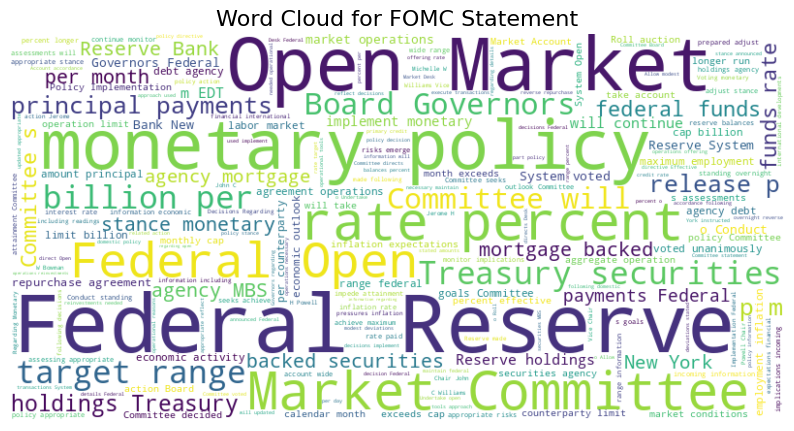

In [ ]:
from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt

# Filter the DataFrame for rows where Category is "statement"
statement_corpus = merged_df[merged_df['Category'] == "FOMC Statement"]['Corpus']

# Combine all text from the filtered Corpus column
text = " ".join(statement_corpus.dropna().astype(str))

# Remove stopwords
custom_stopwords = set(STOPWORDS)
text_without_stopwords = " ".join([word for word in text.split() if word.lower() not in custom_stopwords])

# Generate the word cloud without stopwords
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_without_stopwords)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for FOMC Statement", fontsize=16)
plt.show()

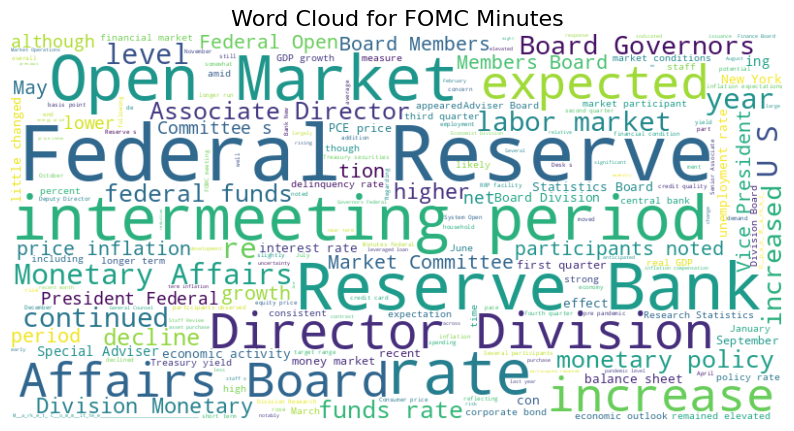

In [ ]:
from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt

# Filter the DataFrame for rows where Category is "statement"
minutes_corpus = merged_df[merged_df['Category'] == "FOMC Minutes"]['Corpus']

# Combine all text from the filtered Corpus column
text = " ".join(minutes_corpus.dropna().astype(str))

# Remove stopwords
custom_stopwords = set(STOPWORDS)
text_without_stopwords = " ".join([word for word in text.split() if word.lower() not in custom_stopwords])

# Generate the word cloud without stopwords
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_without_stopwords)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for FOMC Minutes", fontsize=16)
plt.show()

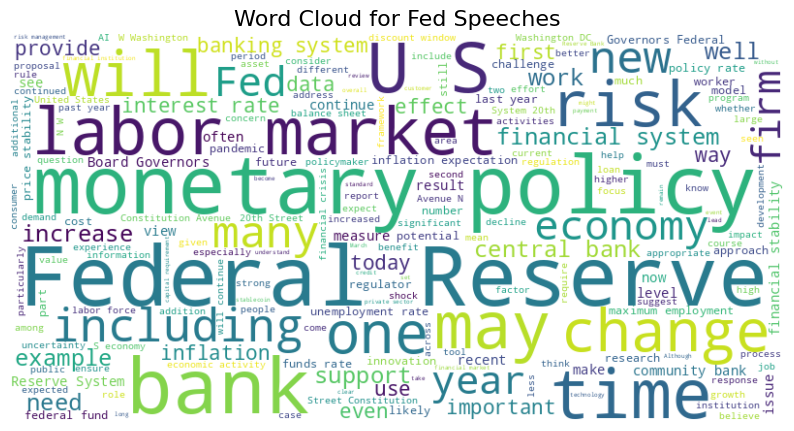

In [ ]:
from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt

# Filter the DataFrame for rows where Category is "statement"
speeches_corpus = merged_df[merged_df['Category'] == "Speeches"]['Corpus']

# Combine all text from the filtered Corpus column
text = " ".join(speeches_corpus.dropna().astype(str))

# Remove stopwords
custom_stopwords = set(STOPWORDS)
text_without_stopwords = " ".join([word for word in text.split() if word.lower() not in custom_stopwords])

# Generate the word cloud without stopwords
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_without_stopwords)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Fed Speeches", fontsize=16)
plt.show()

**Sentiment Time Series**

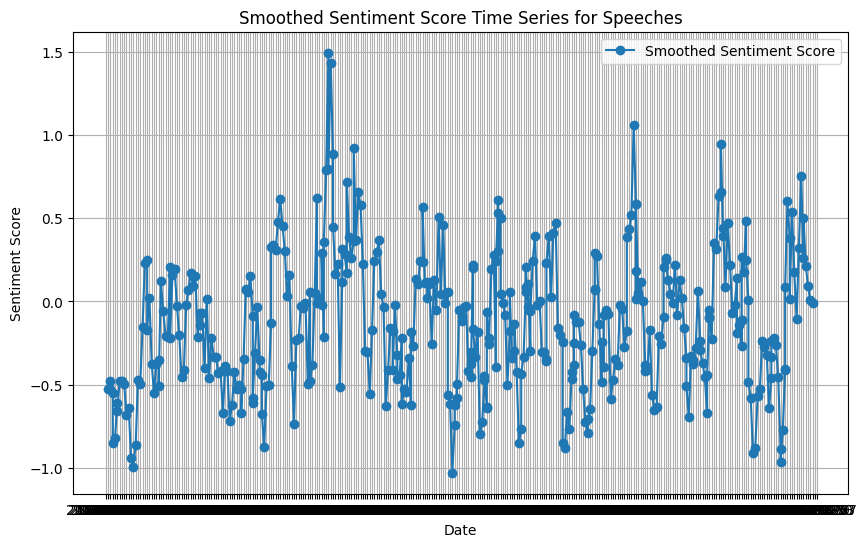

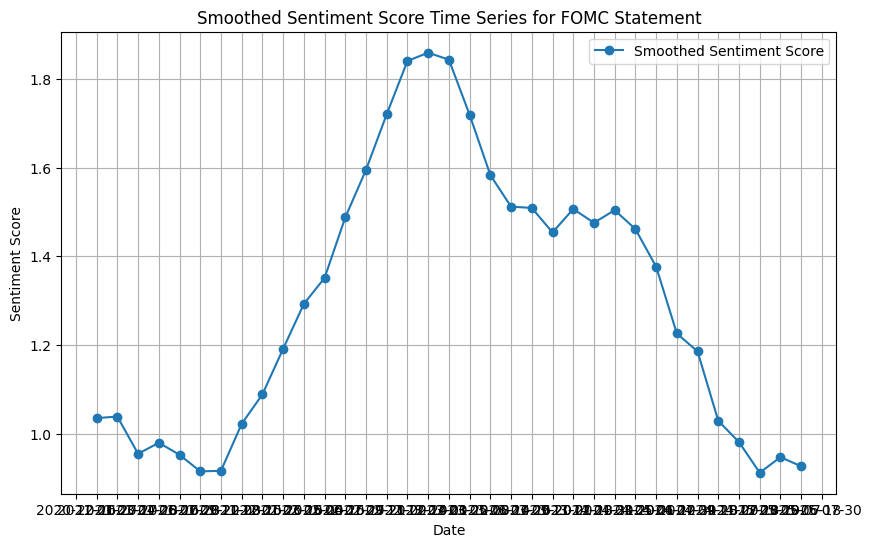

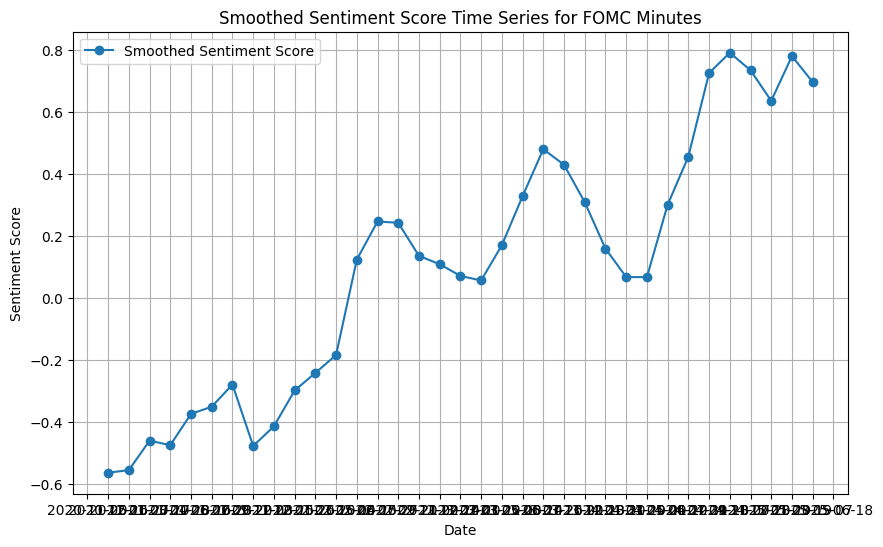

In [ ]:
import matplotlib.pyplot as plt

# Get the list of unique categories
unique_categories = merged_df['Category'].unique()

# Iterate over each category and generate the sentiment score time series
for category in unique_categories:
    # Filter the DataFrame for the current category
    category_df = merged_df[merged_df['Category'] == category]

    # Extract the sentiment score time series
    category_sentiment = category_df[['Date', 'factor_sim_avg_z']].sort_values(by='Date')

    # Apply a rolling average to smooth the sentiment scores
    category_sentiment['Smoothed_Sentiment'] = category_sentiment['factor_sim_avg_z'].rolling(window=5, center=True).mean()

    # Plot the smoothed sentiment score time series
    plt.figure(figsize=(10, 6))
    plt.plot(category_sentiment['Date'], category_sentiment['Smoothed_Sentiment'], marker='o', label='Smoothed Sentiment Score')
    plt.title(f"Smoothed Sentiment Score Time Series for {category}")
    plt.xlabel("Date")
    plt.ylabel("Sentiment Score")
    plt.legend()
    plt.grid()
    plt.show()

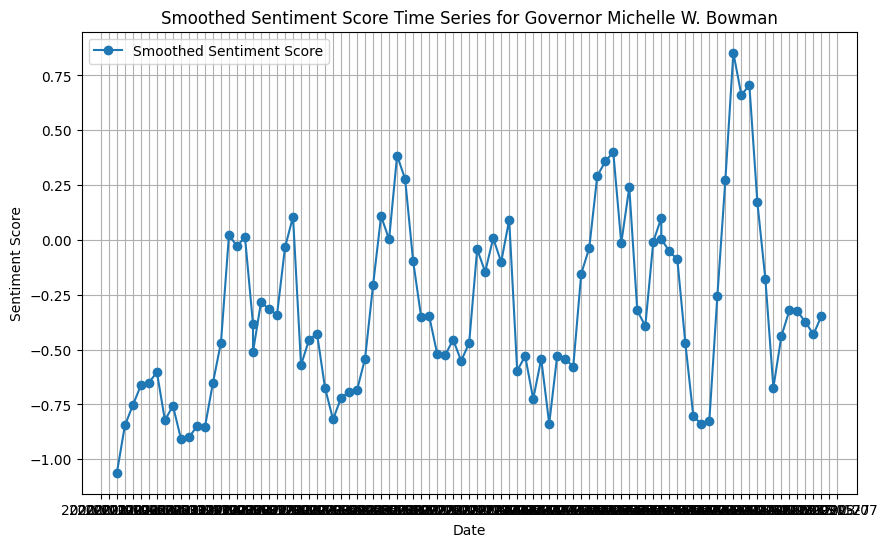

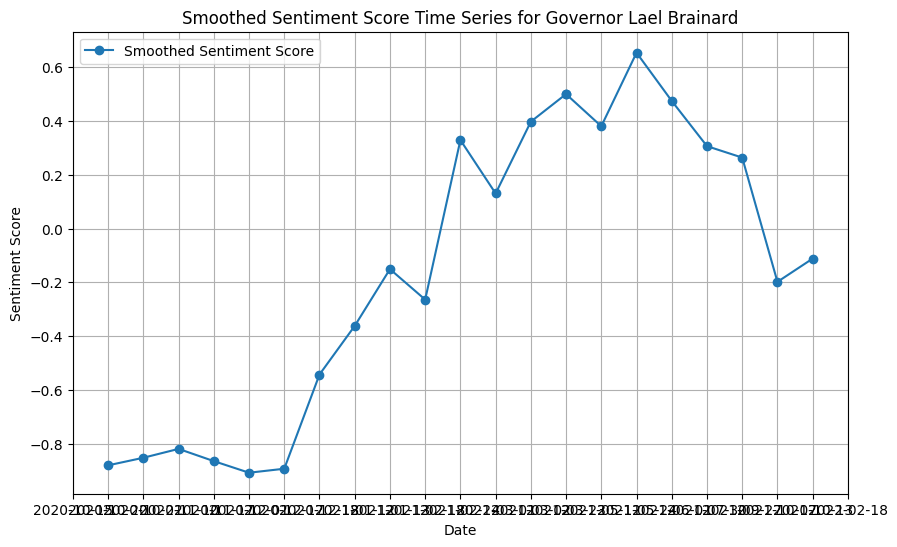

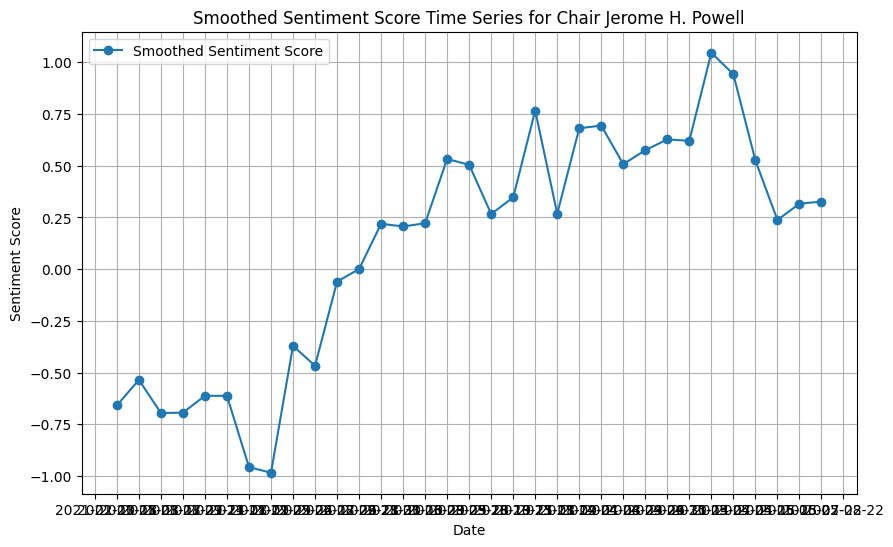

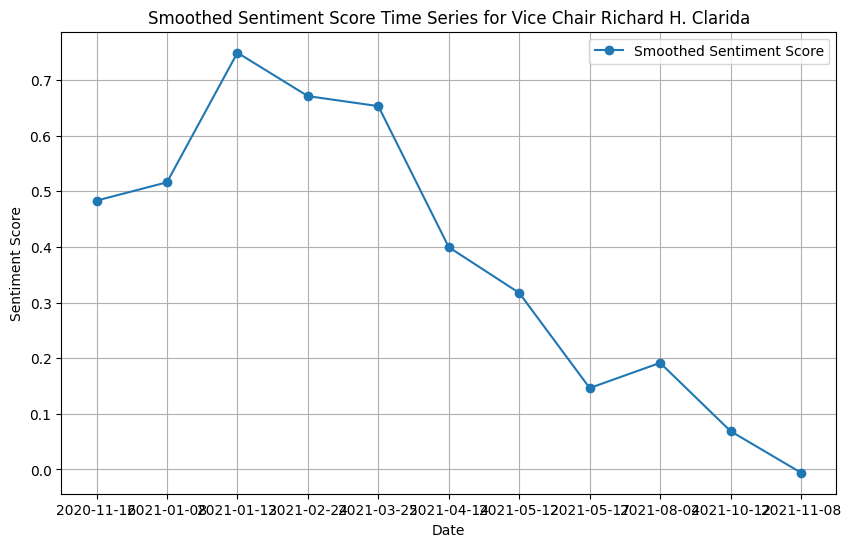

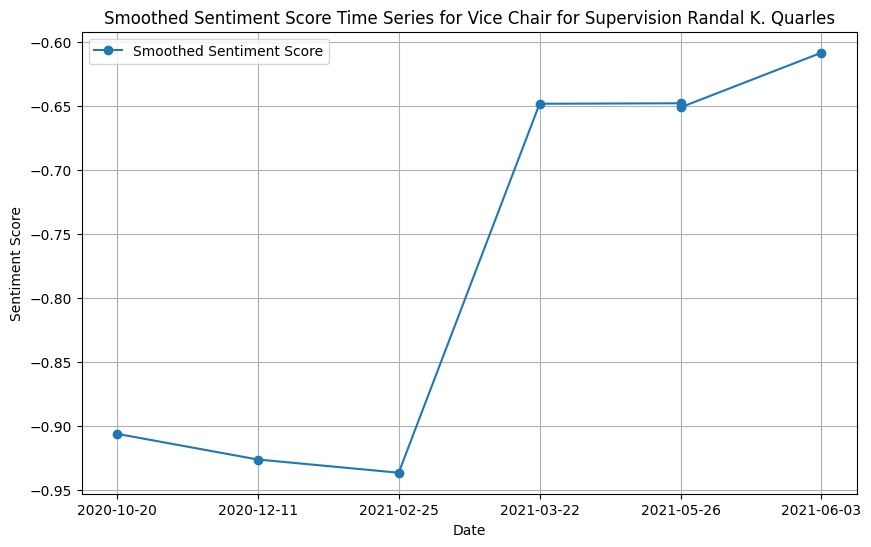

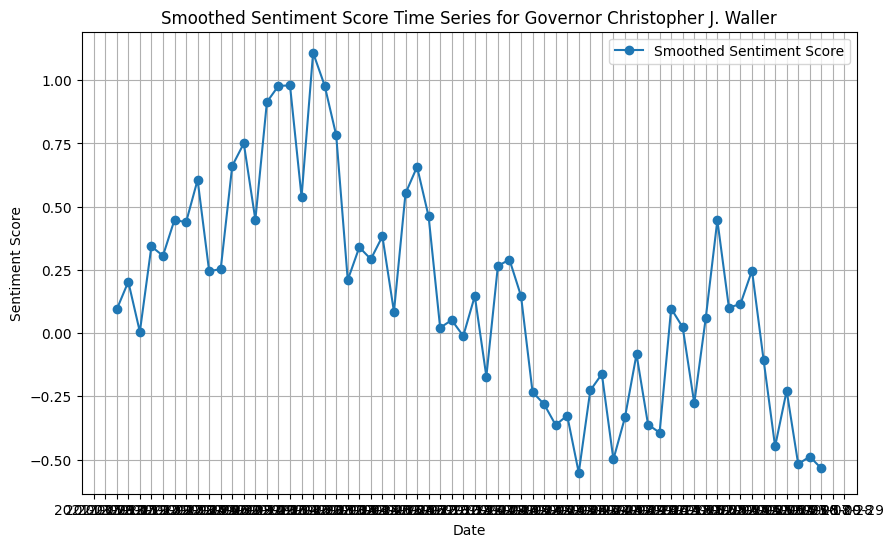

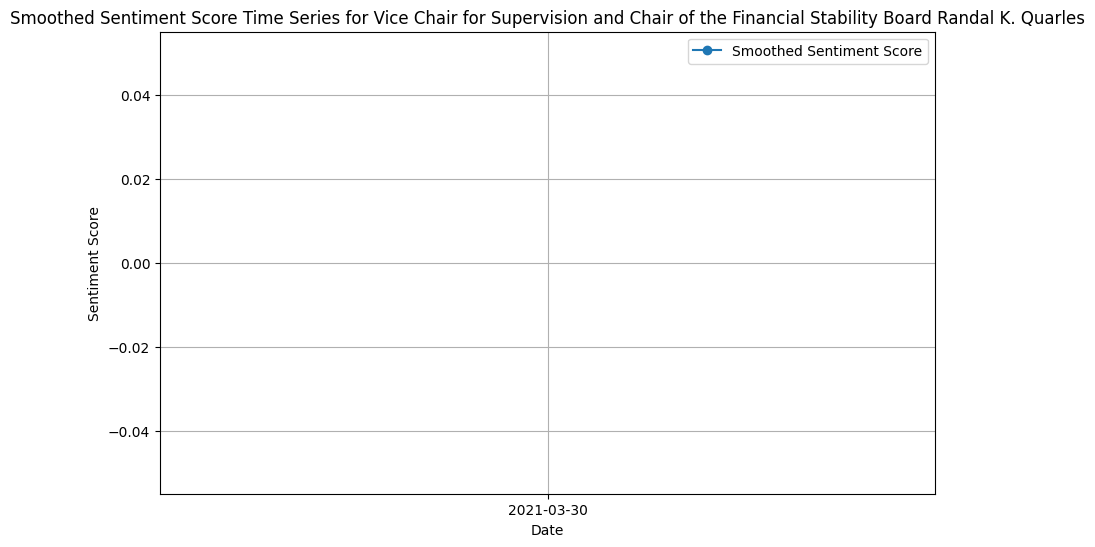

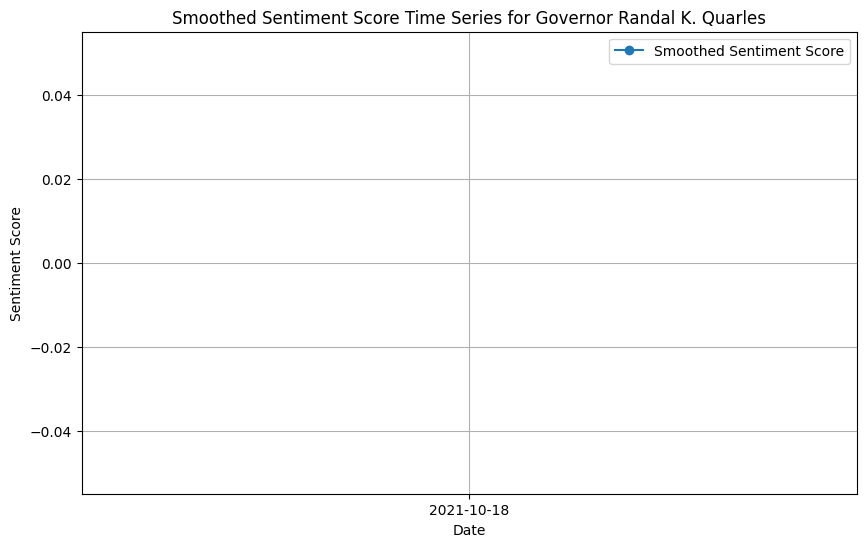

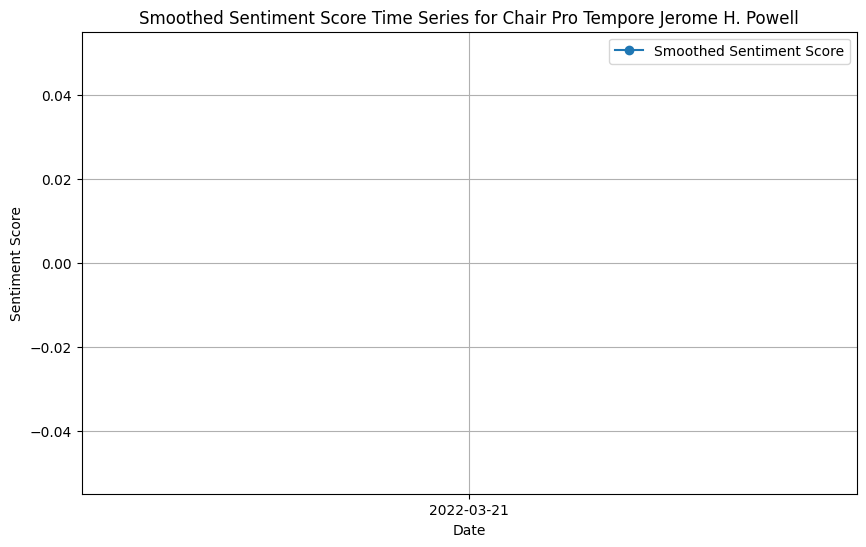

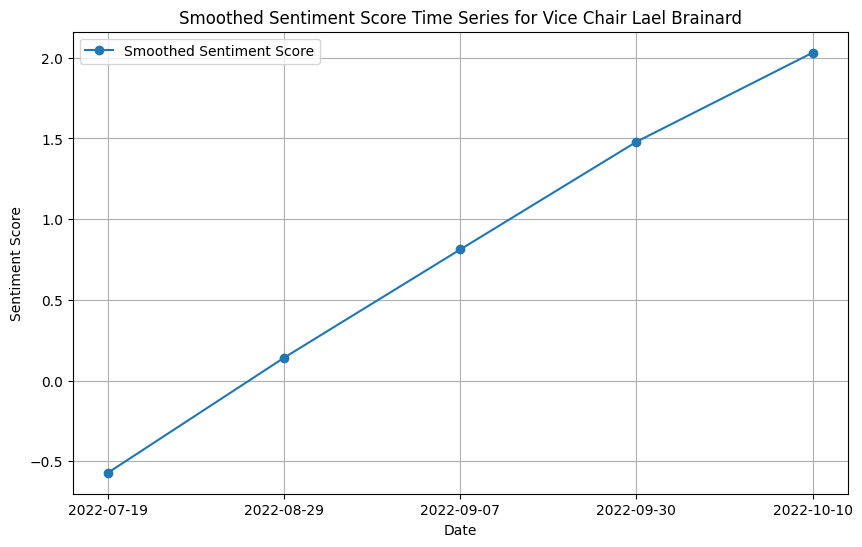

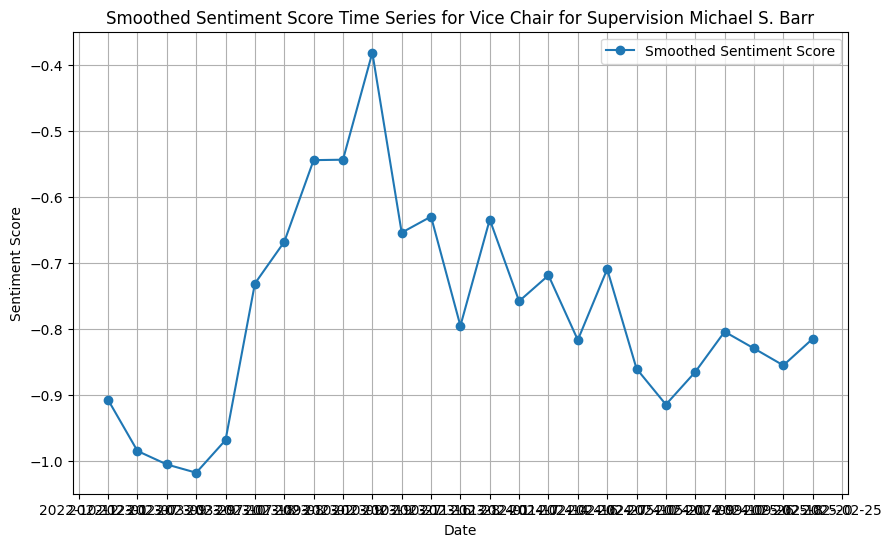

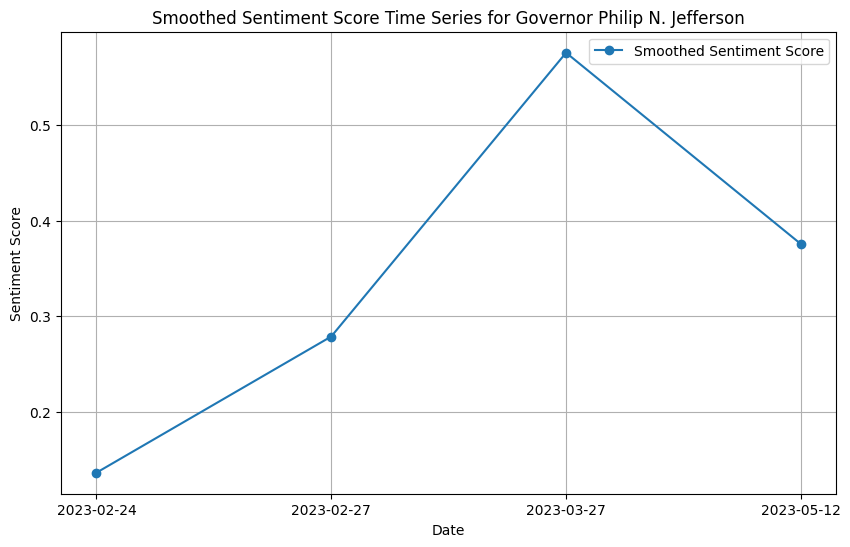

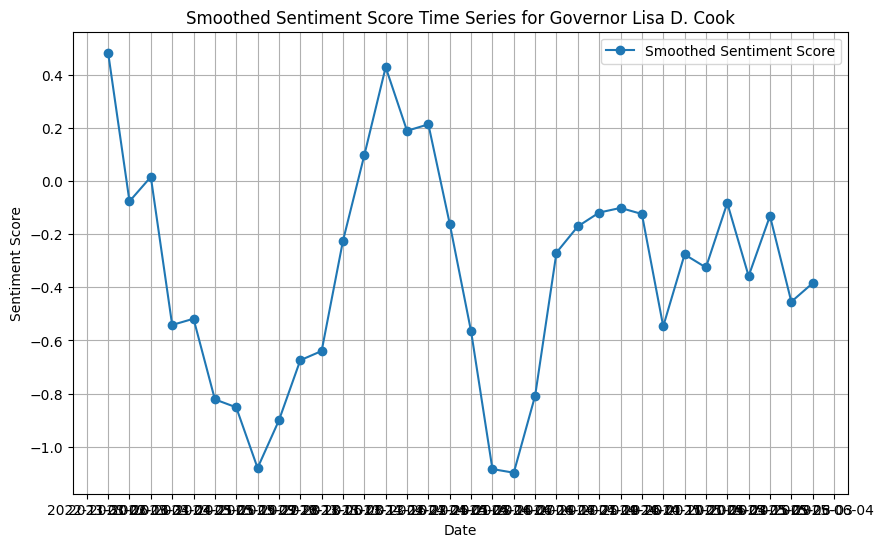

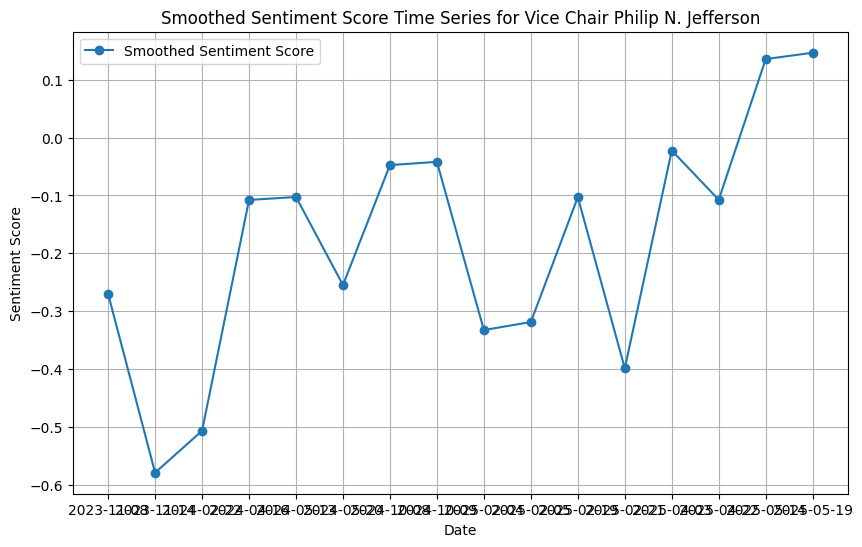

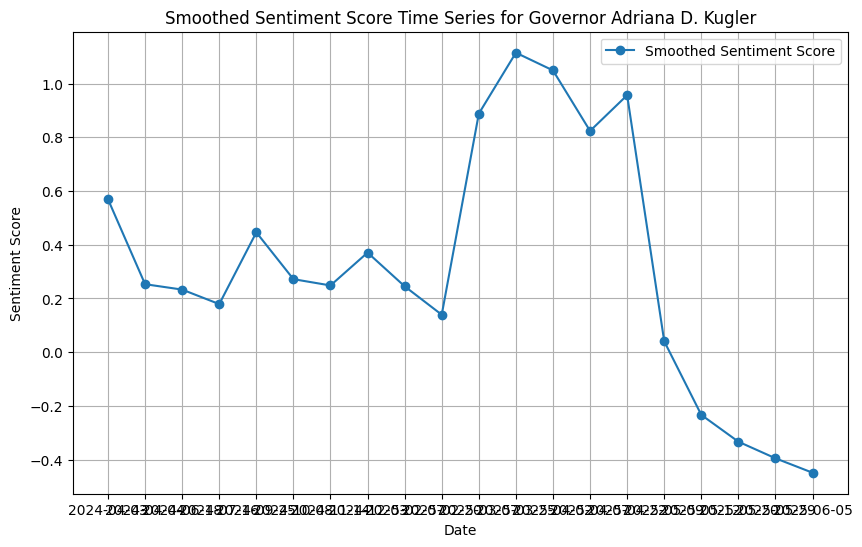

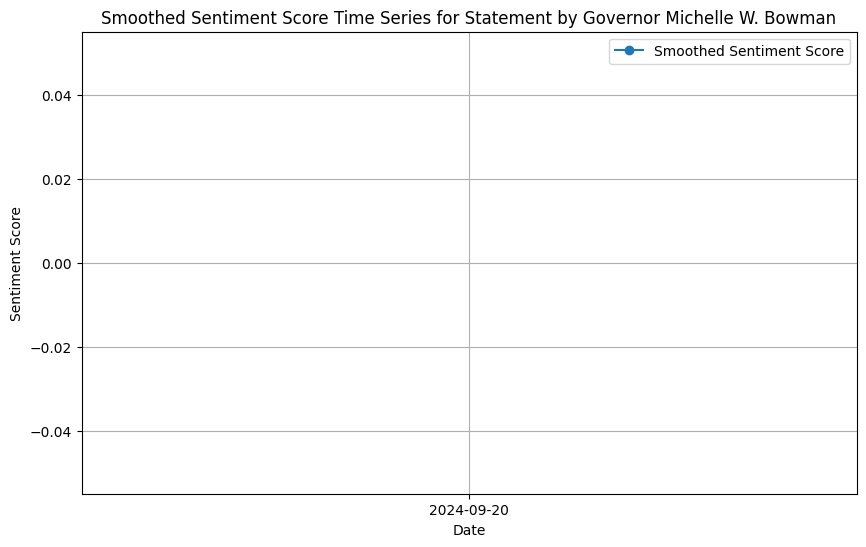

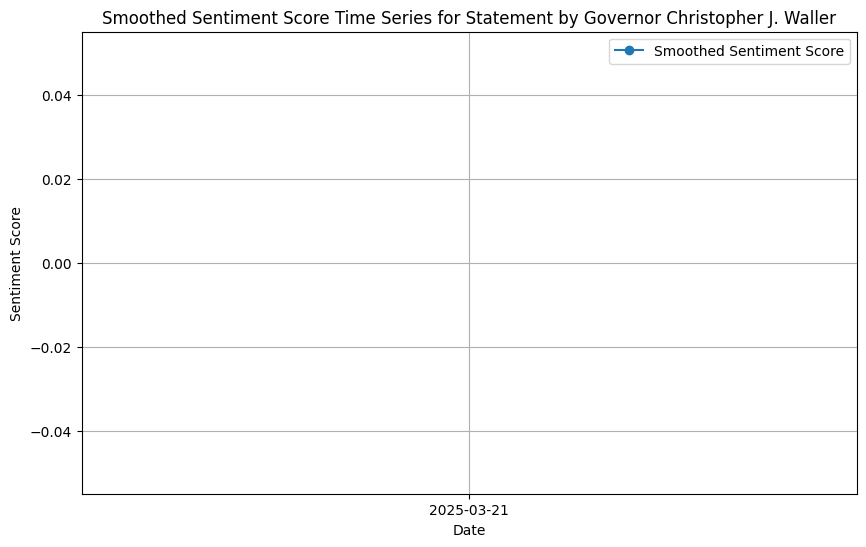

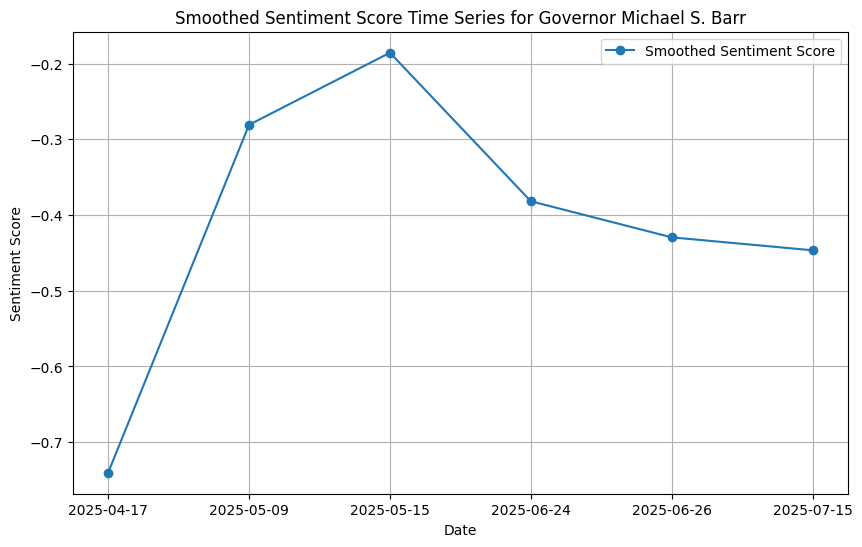

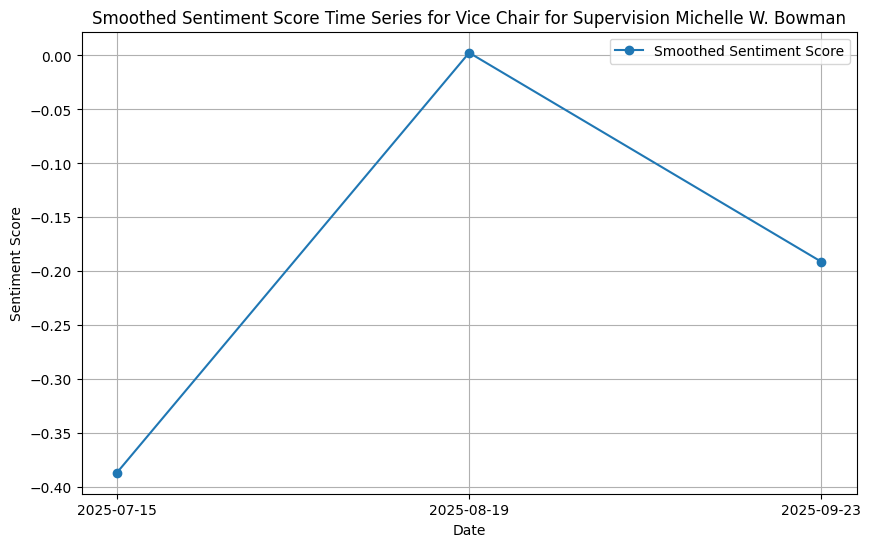

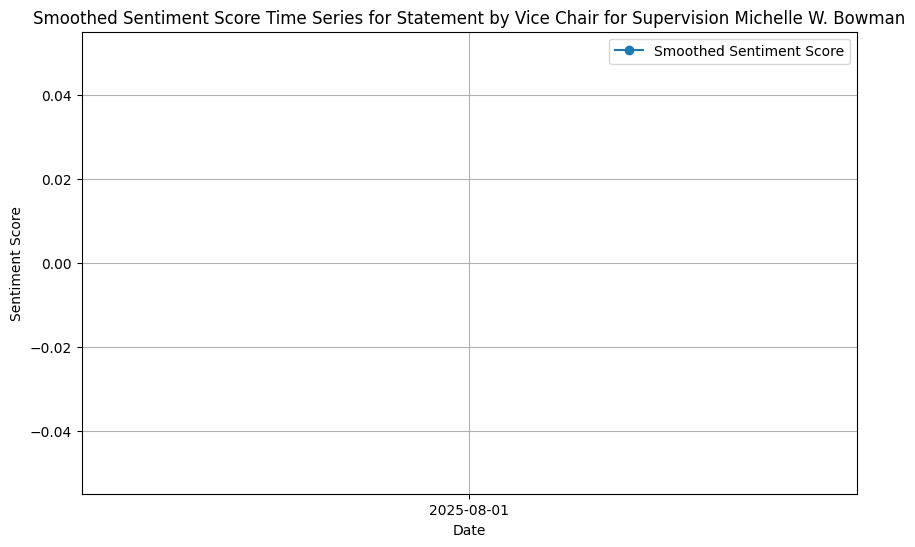

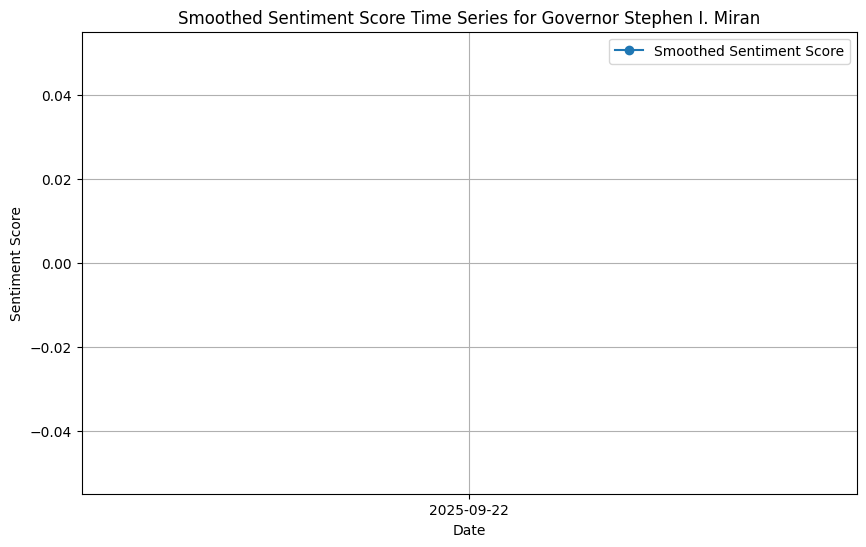

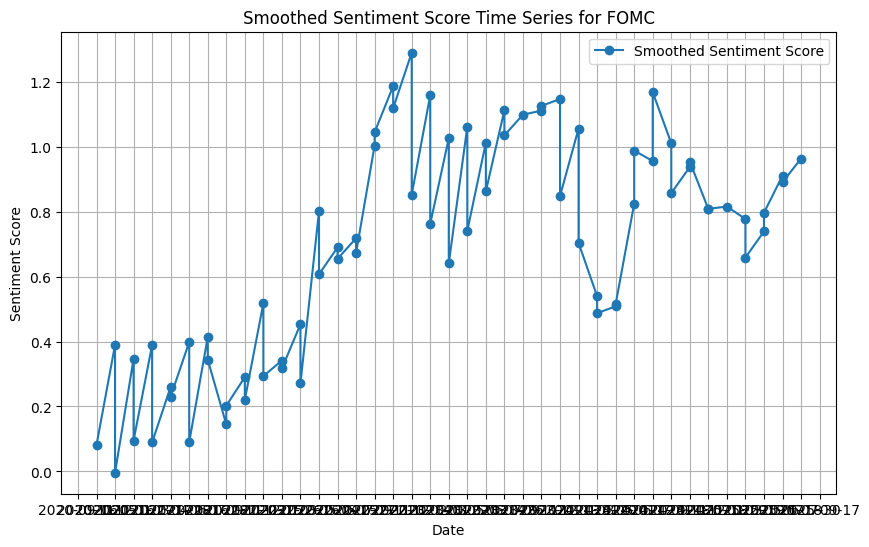

In [ ]:
import matplotlib.pyplot as plt

# Get the list of unique speakers
unique_speakers = merged_df['Speaker'].unique()

# Iterate over each speaker and generate the sentiment score time series
for speaker in unique_speakers:
    # Filter the DataFrame for the current speaker
    speaker_df = merged_df[merged_df['Speaker'] == speaker]

    # Extract the sentiment score time series
    speaker_sentiment = speaker_df[['Date', 'factor_sim_avg_z']].sort_values(by='Date')

    # Apply a rolling average to smooth the sentiment scores
    speaker_sentiment['Smoothed_Sentiment'] = speaker_sentiment['factor_sim_avg_z'].rolling(window=5, center=True).mean()

    # Plot the smoothed sentiment score time series
    plt.figure(figsize=(10, 6))
    plt.plot(speaker_sentiment['Date'], speaker_sentiment['Smoothed_Sentiment'], marker='o', label='Smoothed Sentiment Score')
    plt.title(f"Smoothed Sentiment Score Time Series for {speaker}")
    plt.xlabel("Date")
    plt.ylabel("Sentiment Score")
    plt.legend()
    plt.grid()
    plt.show()

## Update: Method 3

**Notes:**
* The following code cells implements method 3.
* The dataset used are *new_raw_data.csv* and *finbert_segments.csv*.
* An absolute path was used for this part:
    * in def_main(), the line is:
    * speeches_csv = "/Users/sally/Desktop/Fall2025/NLP/Project_2/new_raw_data.csv"
    * to modify, the only thing that needs to be changed is this path.


In [ ]:
'''
This code takes 30 minutes to run, don't run it. Since the results are already saved:
finbert_segments.csv
'''

import os
import re
import argparse
import warnings
from pathlib import Path
from typing import List

import numpy as np
import pandas as pd
from tqdm import tqdm

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline
import torch
import statsmodels.api as sm

warnings.filterwarnings("ignore", category=FutureWarning)

TARGET_COLS_DEFAULT = {"d1y":"d1y","d10y2y":"d10y2y","dusd":"dusd","dgv":"dgv"}
BATCH_SIZE = 16

def read_text_for_row(row: pd.Series) -> str:
    # Try the Corpus column (from new_raw_data.csv)
    corpus_val = row.get("Corpus")
    if pd.notna(corpus_val):
        txt = str(corpus_val).strip()
        if len(txt) > 50:
            return txt

    # Try the full_text column (from fed_FMOC_local.csv)
    full_text_val = row.get("full_text")
    if pd.notna(full_text_val):
        txt = str(full_text_val).strip()
        if len(txt) > 50:
            return txt

    # Fallback to text column
    text_val = row.get("text")
    if pd.notna(text_val):
        txt = str(text_val).strip()
        if len(txt) > 50:
            return txt

    # Fallback to reading from text files
    source_file = row.get("source_file")
    if not source_file: return ""
    p = Path(source_file).with_suffix(".txt")
    if p.exists():
        try: return p.read_text(encoding="utf-8", errors="ignore")
        except Exception: return p.read_text(encoding="latin-1", errors="ignore")
    try: return Path(source_file).read_text(encoding="utf-8", errors="ignore")
    except Exception: return ""

def sentence_tokenize(text: str):
    text = re.sub(r"\s+", " ", text.strip())
    sents = re.split(r"(?<=[\.!\?])\s+", text)
    return [s for s in sents if s]

def split_into_three_segments(sents):
    if not sents: return [[],[],[]]
    n = len(sents); k = n//3
    seg1 = sents[:k] if k>0 else sents[:max(1, n//3)]
    seg2 = sents[k:2*k] if k>0 else sents[max(1, n//3):max(2, n//3)]
    seg3 = sents[2*k:] if k>0 else sents[max(2, n//3):]
    if len(seg2)==0 and len(seg3)>1:
        seg2 = seg3[:1]; seg3 = seg3[1:]
    return [seg1, seg2, seg3]
def load_finbert():
    model_name = "ProsusAI/finbert"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    device = 0 if torch.cuda.is_available() else -1
    pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True, device=device, truncation=True)
    return pipe

def score_sentences(pipe, sents):
    probs = []
    # Process sentences in batches
    for i in range(0, len(sents), BATCH_SIZE):
        batch = sents[i:i+BATCH_SIZE]
        outs = pipe(batch)
        for o in outs:
            scores = {d['label'].lower(): d['score'] for d in o}
            probs.append([scores.get('positive',0.0), scores.get('neutral',0.0), scores.get('negative',0.0)])
    return np.array(probs) if probs else np.zeros((0,3))

def aggregate_segment(probs, sents, weighted=False):
    if probs.shape[0]==0: return float("nan")
    pos = probs[:,0]
    if weighted:
        w = np.array([max(1, len(s.split())) for s in sents], dtype=float)
        return float(np.average(pos, weights=w))
    return float(np.mean(pos))

def build_features_for_row(row, pipe, weighted=False):
    text = read_text_for_row(row)
    sents = sentence_tokenize(text)
    segs = split_into_three_segments(sents)
    feats = {}
    for i, seg in enumerate(segs, start=1):
        probs = score_sentences(pipe, seg)
        feats[f"seg{i}_pos"] = aggregate_segment(probs, seg, weighted=weighted)
        feats[f"seg{i}_n"] = len(seg)
    feats["n_sents_total"] = len(sents)
    return feats

def regress_market(y, X, add_const=True):
    Xr = sm.add_constant(X) if add_const else X
    model = sm.OLS(y, Xr, missing='drop')
    res = model.fit(cov_type="HC1")
    return res
def main():
    # For notebook use, set parameters directly instead of using argparse
    speeches_csv = "/Users/sally/Desktop/Fall2025/NLP/Project_2/new_raw_data.csv"  # Your CSV with full text
    market_csv = None  # Add path to your market data CSV if you have one
    out_features = "finbert_segments.csv"
    weighted = False
    targets = None  # JSON mapping if needed

    # Create an args-like object for compatibility with existing code
    class Args:
        def __init__(self):
            self.speeches_csv = speeches_csv
            self.market_csv = market_csv
            self.out_features = out_features
            self.weighted = weighted
            self.targets = targets

    args = Args()

    print("📊 Loading data...")
    df = pd.read_csv(args.speeches_csv)
    if "Date" not in df.columns: raise ValueError("speeches_csv must have 'Date'")
    df["Date"] = pd.to_datetime(df["Date"]).dt.date
    print(f"✅ Loaded {len(df)} speeches")

    print("🤖 Loading FinBERT model...")
    pipe = load_finbert()
    print("✅ FinBERT model loaded")

    print("🔄 Processing speeches with FinBERT...")
    rows = []
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Analyzing speeches"):
        feats = build_features_for_row(row, pipe, weighted=args.weighted)
        feats["Date"] = row["Date"]
        feats["source_file"] = row.get("source_file", "")
        rows.append(feats)

    print("📋 Creating results dataframe...")
    feats_df = pd.DataFrame(rows).sort_values("Date").reset_index(drop=True)
    feats_df.to_csv(args.out_features, index=False)
    print(f"[OK] features -> {args.out_features}, N={len(feats_df)}")

    if args.market_csv:
        import json
        tmap = TARGET_COLS_DEFAULT
        if args.targets:
            tmap = json.loads(args.targets)
        mkt = pd.read_csv(args.market_csv)
        if "Date" not in mkt.columns: raise ValueError("market_csv must have 'Date'")
        mkt["Date"] = pd.to_datetime(mkt["Date"]).dt.date
        merged = pd.merge(feats_df, mkt, on="Date", how="inner")
        X = merged[["seg1_pos","seg2_pos","seg3_pos"]]
        for key, col in tmap.items():
            if col not in merged.columns:
                print(f"[WARN] missing target '{col}', skip")
                continue
            y = merged[col]
            res = regress_market(y, X, add_const=True)
            print("\n" + "="*70)
            print(f"Regression: {key} (N={int(res.nobs)}) weighted={args.weighted}")
            print(res.summary().as_text())

# Run the FinBERT analysis
if __name__ == "__main__" or True:  # Force execution in notebook
    main()


'''
📊 Loading data...
✅ Loaded 483 speeches
🤖 Loading FinBERT model...
Device set to use cpu
/opt/miniconda3/envs/NLP/lib/python3.13/site-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
/opt/miniconda3/envs/NLP/lib/python3.13/site-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
✅ FinBERT model loaded
🔄 Processing speeches with FinBERT...
Analyzing speeches: 100%|██████████| 483/483 [31:28<00:00,  3.91s/it]
📋 Creating results dataframe...
[OK] features -> finbert_segments.csv, N=483
'''

In [ ]:
# Display Results Summary

'''
Datasets:
results_df: load finbert_segments.csv
df:         load new_raw_data.csv

Please upload these 2 datasets into colab in order to run this and the following cells.
'''

df=pd.read_csv("new_raw_data.csv")

try:
    # Load and display the results
    results_df = pd.read_csv("finbert_segments.csv")

    print("📊 FINBERT ANALYSIS RESULTS")
    print("=" * 50)
    print(f"✅ Total speeches processed: {len(results_df)}")
    print(f"📅 Date range: {results_df['Date'].min()} to {results_df['Date'].max()}")
    print(f"📊 Features generated: {list(results_df.columns)}")

    # Show sample results
    print(f"\n📋 Sample Results (first 3 speeches):")
    display_cols = ['Date', 'seg1_pos', 'seg2_pos', 'seg3_pos', 'seg1_n', 'seg2_n', 'seg3_n', 'n_sents_total']
    print(results_df[display_cols].head(3).to_string(index=False))

    # Show summary statistics
    print(f"\n📈 Sentiment Score Statistics:")
    sentiment_cols = ['seg1_pos', 'seg2_pos', 'seg3_pos']
    print(results_df[sentiment_cols].describe().round(4))

    print(f"\n💾 Results saved to: finbert_segments.csv")

except FileNotFoundError:
    print("❌ Results file not found. Please run the analysis first.")
except Exception as e:
    print(f"❌ Error loading results: {e}")

📊 FINBERT ANALYSIS RESULTS
✅ Total speeches processed: 483
📅 Date range: 2020-09-16 to 2025-10-07
📊 Features generated: ['seg1_pos', 'seg1_n', 'seg2_pos', 'seg2_n', 'seg3_pos', 'seg3_n', 'n_sents_total', 'Date', 'source_file']

📋 Sample Results (first 3 speeches):
      Date  seg1_pos  seg2_pos  seg3_pos  seg1_n  seg2_n  seg3_n  n_sents_total
2020-09-16  0.079730  0.307937  0.437165      80      80      82            242
2020-10-01  0.287995  0.335913  0.369023      12      12      14             38
2020-10-01  0.505993  0.315589  0.488577      14      14      14             42

📈 Sentiment Score Statistics:
       seg1_pos  seg2_pos  seg3_pos
count  483.0000  482.0000  482.0000
mean     0.2611    0.2576    0.2515
std      0.1070    0.1215    0.1152
min      0.0331    0.0426    0.0394
25%      0.1739    0.1649    0.1656
50%      0.2576    0.2516    0.2530
75%      0.3310    0.3354    0.3392
max      0.7106    0.7559    0.5808

💾 Results saved to: finbert_segments.csv


In [ ]:
# Check available columns in the merged dataframe
print("📊 Available columns in merged dataframe:")
print("=" * 50)
print(f"Total columns: {len(df.columns)}")
print("\nColumn names:")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:2d}. {col}")

print(f"\n📋 Sample of merged data:")
print(df.head())

print(f"\n🔍 Checking for columns that might contain 'surprise':")
surprise_cols = [col for col in df.columns if 'surprise' in col.lower()]
if surprise_cols:
    print(f"Found surprise-related columns: {surprise_cols}")
else:
    print("No columns containing 'surprise' found")

print(f"\n💡 Suggested X variables (FinBERT sentiment only):")
sentiment_cols = [col for col in df.columns if col.startswith('seg') and col.endswith('_pos')]
print(f"Sentiment columns: {sentiment_cols}")

# if sentiment_cols:
#    print(f"\n✅ Recommended X definition:")
#    print(f"X = df[{sentiment_cols}]")
#else:
#    print("\n❌ No sentiment columns found")


📊 Available columns in merged dataframe:
Total columns: 11

Column names:
   1. Date
   2. Category
   3. Speaker
   4. Corpus
   5. USYC2Y10 Change
   6. Growth-Value Spread
   7. DXY Change %
   8. 2Y Yield Change
   9. seg1_pos
  10. seg2_pos
  11. seg3_pos

📋 Sample of merged data:
        Date  Category                      Speaker  \
0 2020-10-01  Speeches  Governor Michelle W. Bowman   
1 2020-10-01  Speeches  Governor Michelle W. Bowman   
2 2020-10-01  Speeches       Governor Lael Brainard   
3 2020-10-01  Speeches       Governor Lael Brainard   
4 2020-10-06  Speeches       Chair Jerome H. Powell   

                                              Corpus  USYC2Y10 Change  \
0  Good afternoon, everyone. Thank you to Montana...           -0.657   
1  Good afternoon, everyone. Thank you to Montana...           -0.657   
2  Governor Lael Brainard\n\nTo the Independent C...           -0.657   
3  Governor Lael Brainard\n\nTo the Independent C...           -0.657   
4  Good morning. 

In [ ]:
# Regression

import pandas as pd
import statsmodels.api as sm

# 1 read main data and FinBERT features
raw = pd.read_csv("new_raw_data.csv")
fin = pd.read_csv("finbert_segments.csv")

# make sure Date columns are datetime
raw['Date'] = pd.to_datetime(raw['Date'])
fin['Date'] = pd.to_datetime(fin['Date'])

# 2 merge on Date
df = pd.merge(raw, fin[['Date','seg1_pos','seg2_pos','seg3_pos']], on='Date', how='left')

# 3 define independent variables (using available FinBERT sentiment scores)


# First check what columns are available
available_sentiment_cols = [col for col in df.columns if col.startswith('seg') and col.endswith('_pos')]
print(f"Available sentiment columns: {available_sentiment_cols}")

if len(available_sentiment_cols) >= 3:
    X = df[['seg1_pos','seg2_pos','seg3_pos']]
    print("✅ Using FinBERT sentiment scores as predictors")
else:
    print("❌ Not enough sentiment columns found")
    print("Available columns:", df.columns.tolist())

X = sm.add_constant(X)

# 4 check available dependent variables
print(f"\n🎯 Checking for dependent variables:")
market_change_cols = [col for col in df.columns if any(keyword in col.lower() for keyword in ['change', 'return', 'car', 'yield', 'spread'])]
print(f"Available market change columns: {market_change_cols}")

# Try to find the best available dependent variable
if 'CAR_0p1' in df.columns:
    y = df['CAR_0p1']
    dep_var_name = 'CAR_0p1'
    print(f"✅ Using CAR_0p1 as dependent variable")
elif market_change_cols:
    dep_var_name = market_change_cols[0]
    y = df[dep_var_name]
    print(f"✅ Using {dep_var_name} as dependent variable")
else:
    print("❌ No suitable dependent variable found")
    print("Available columns:", [col for col in df.columns if 'change' in col.lower() or 'yield' in col.lower()])
    # Use a fallback if available
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    if len(numeric_cols) > 0:
        dep_var_name = numeric_cols[0]
        y = df[dep_var_name]
        print(f"🔄 Using fallback variable: {dep_var_name}")
    else:
        print("❌ No numeric columns available for regression")
        dep_var_name = None

# 5 run regression only if valid variables are available
if dep_var_name is not None and len(available_sentiment_cols) >= 3:
    print(f"\n📊 Running regression: {dep_var_name} ~ seg1_pos + seg2_pos + seg3_pos")

    # Remove any rows with missing values in key columns
    regression_data = df[['seg1_pos', 'seg2_pos', 'seg3_pos', dep_var_name]].dropna()
    print(f"📈 Regression sample size: {len(regression_data)} observations")

    if len(regression_data) > 10:  # Need enough observations
        X_clean = sm.add_constant(regression_data[['seg1_pos', 'seg2_pos', 'seg3_pos']])
        y_clean = regression_data[dep_var_name]

        model = sm.OLS(y_clean, X_clean)
        res = model.fit(cov_type='HC1')

        print("\n" + "="*80)
        print(f"📋 REGRESSION RESULTS: {dep_var_name}")
        print("="*80)
        print(res.summary())
    else:
        print(f"❌ Insufficient observations for regression: {len(regression_data)}")
else:
    print("❌ Cannot run regression - missing required variables")

# 6 Export results
out = pd.DataFrame({
    "coef": res.params,
    "robust_se": res.bse,
    "t": res.tvalues,
    "pval": res.pvalues,
})
out.to_csv("Method3_FinBERT_results.csv")
out


Available sentiment columns: ['seg1_pos', 'seg2_pos', 'seg3_pos']
✅ Using FinBERT sentiment scores as predictors

🎯 Checking for dependent variables:
Available market change columns: ['USYC2Y10 Change', 'Growth-Value Spread', 'DXY Change %', '2Y Yield Change']
✅ Using USYC2Y10 Change as dependent variable

📊 Running regression: USYC2Y10 Change ~ seg1_pos + seg2_pos + seg3_pos
📈 Regression sample size: 779 observations

📋 REGRESSION RESULTS: USYC2Y10 Change
                            OLS Regression Results                            
Dep. Variable:        USYC2Y10 Change   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     4.419
Date:                Mon, 13 Oct 2025   Prob (F-statistic):            0.00431
Time:                        01:05:26   Log-Likelihood:                -2257.0
No. Observations:                 779   AIC:                     

,coef,robust_se,t,pval
const,-0.033564,0.582036,-0.057667,0.954014
seg1_pos,-1.344197,1.466267,-0.916748,0.359275
seg2_pos,-2.847325,1.447366,-1.967246,0.049155
seg3_pos,4.922836,1.561816,3.151994,0.001622


## **Analysis Results**

### **Regression Summary:**
- **Dependent Variable**: `USYC2Y10 Change` (yield curve spread changes)
- **Independent Variables**: FinBERT sentiment scores from speech segments
- **Sample Size**: 779 observations
- **R-squared**: 0.013 (1.3% of variance explained)

### **Key Findings:**
1. **seg2_pos** (middle segment sentiment): **Significantly negative** effect (-2.85, p=0.049)
2. **seg3_pos** (ending segment sentiment): **Significantly positive** effect (+4.92, p=0.002)
3. **seg1_pos** (opening segment sentiment): Not significant (p=0.359)

### **Financial Interpretation:**
- **Positive sentiment in speech endings** → **Steepening yield curve** (longer rates rise more)
- **Positive sentiment in speech middles** → **Flattening yield curve** (shorter rates rise more)
- This suggests markets react differently to sentiment depending on **where in the speech** it appears!
